No hay suficientes datos para calcular ACF/PACF para ACI en la zona Laguna.


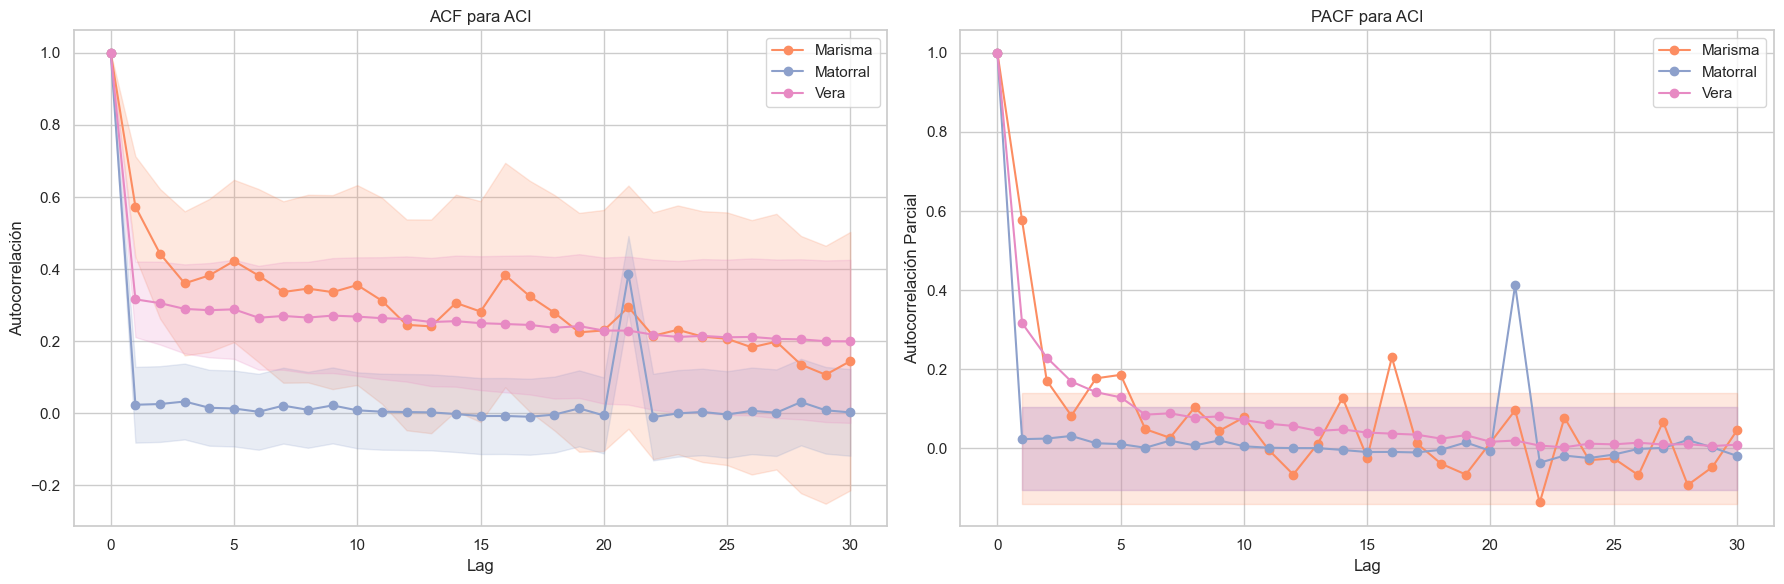

No hay suficientes datos para calcular ACF/PACF para ADI en la zona Laguna.


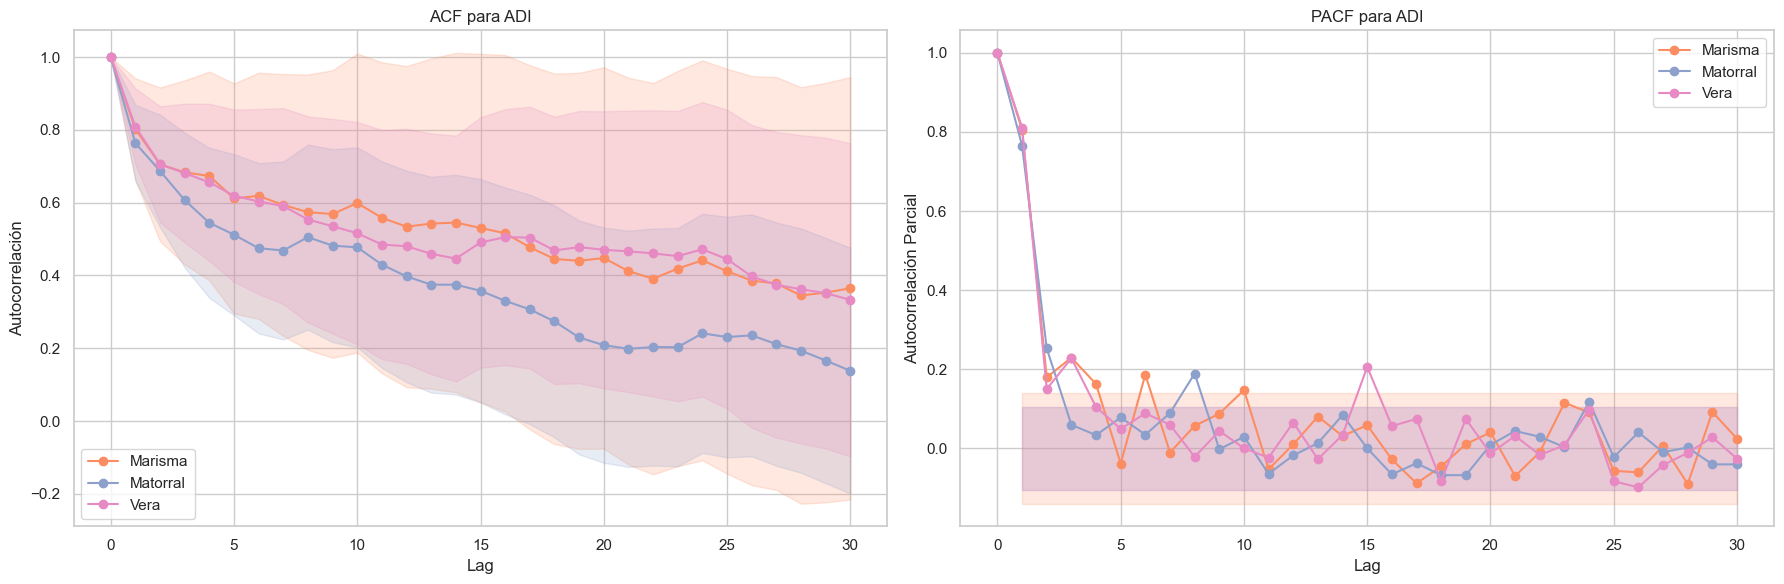

No hay suficientes datos para calcular ACF/PACF para AEI en la zona Laguna.


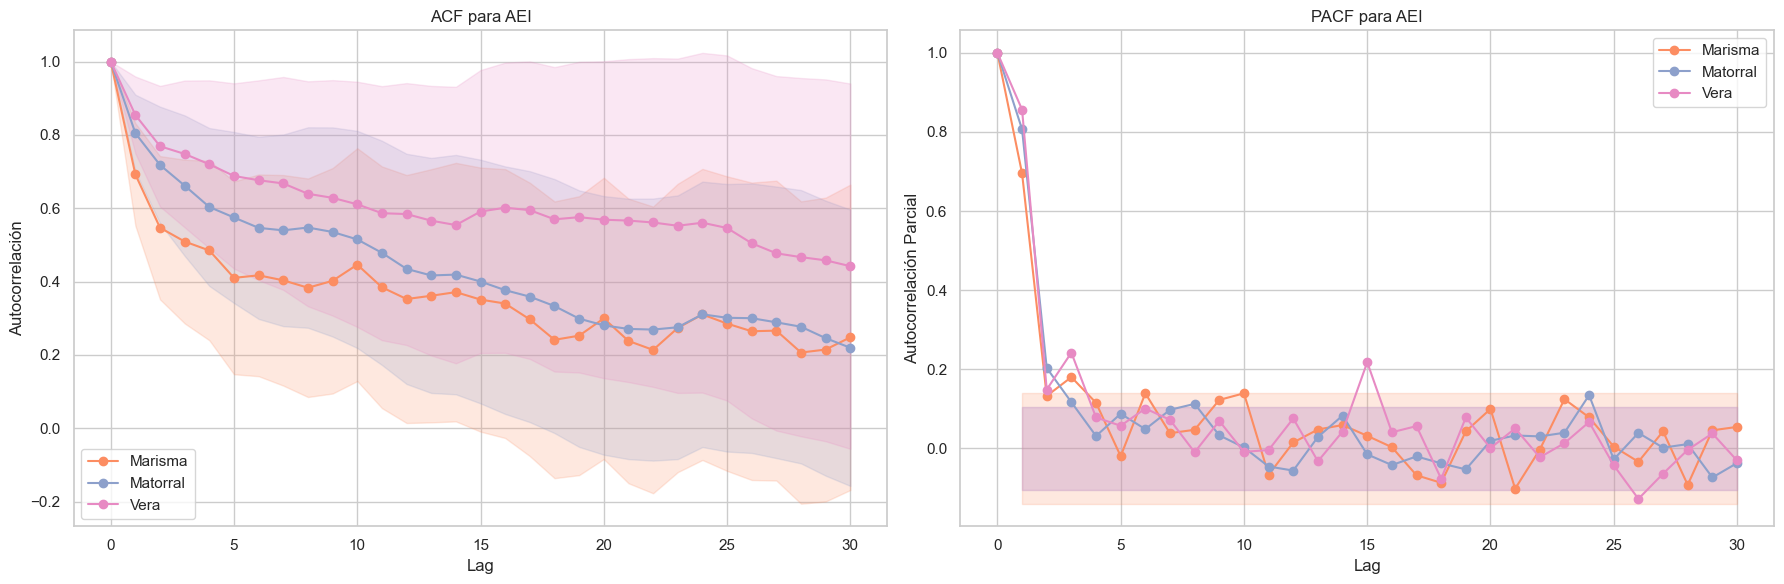

No hay suficientes datos para calcular ACF/PACF para BIO en la zona Laguna.


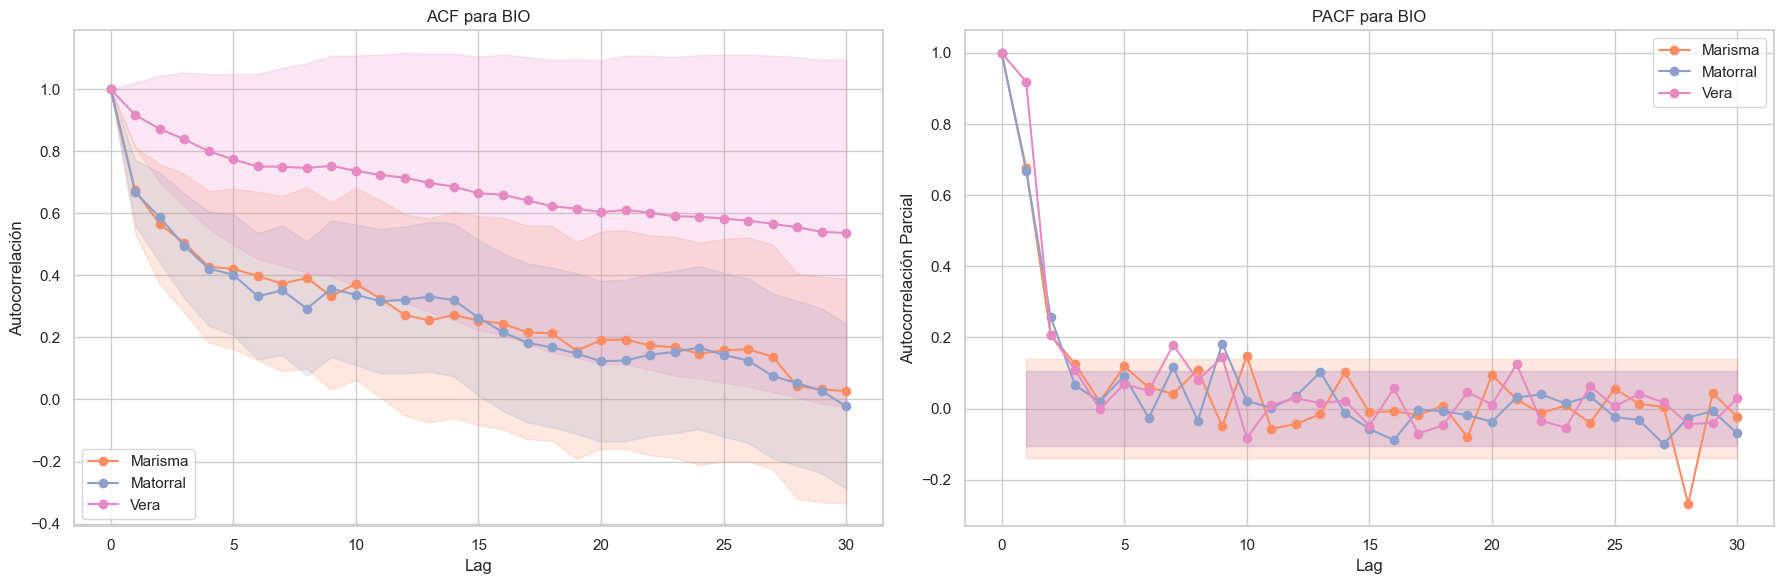

No hay suficientes datos para calcular ACF/PACF para NDSI en la zona Laguna.


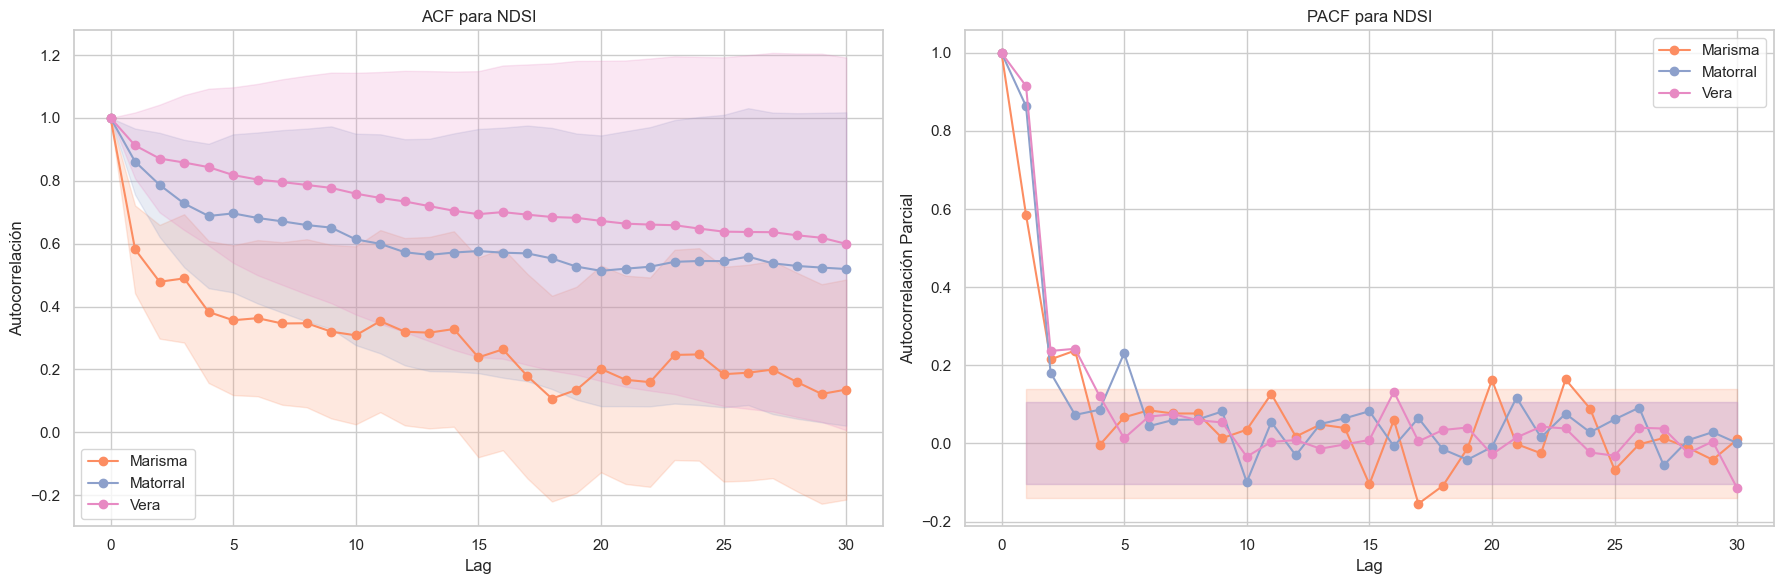

No hay suficientes datos para calcular ACF/PACF para H en la zona Laguna.


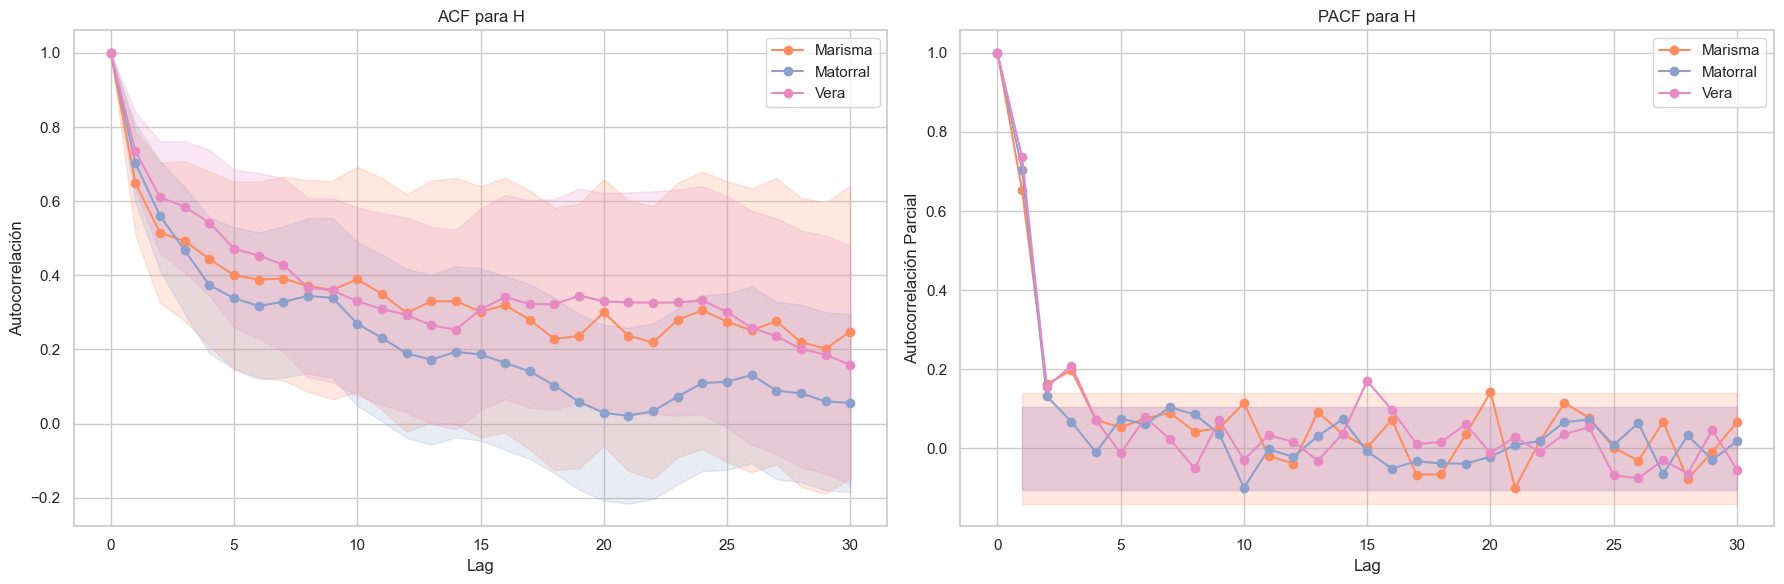

No hay suficientes datos para calcular ACF/PACF para AR en la zona Laguna.


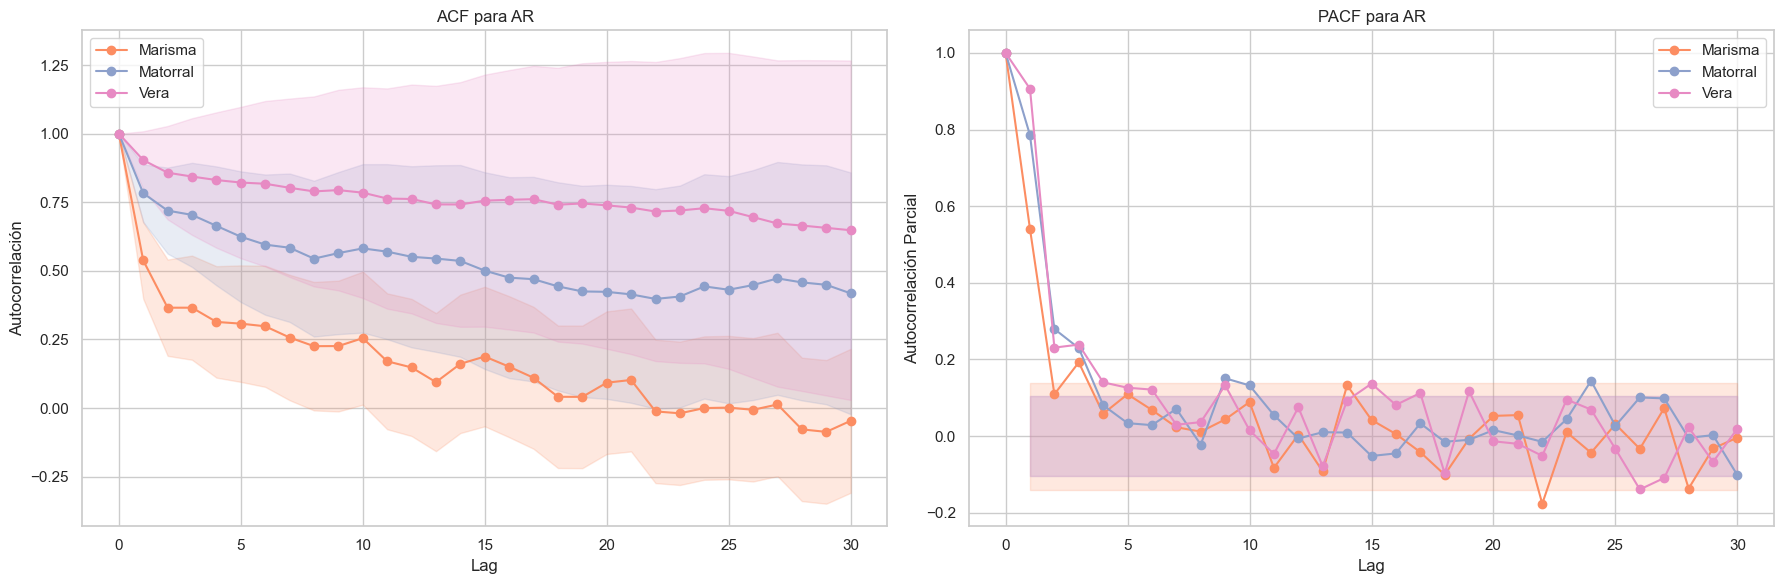

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import acf, pacf

# --- 1. Conexión y extracción de datos desde SQLite ---
db_path = "../../db/audio_metadata.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM audio_metadata WHERE processed = TRUE", conn)
conn.close()

# Convertir "datetime" a tipo datetime y crear la columna "day"
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["day"] = df["datetime"].dt.date

# Convertir la columna 'day' a datetime para facilitar la reindexación
df["day"] = pd.to_datetime(df["day"])

# --- Filtrar datos entre marzo 2023 y marzo 2024 ---
start_date = pd.to_datetime("2023-03-01")
end_date = pd.to_datetime("2024-03-31")
df = df[(df["day"] >= start_date) & (df["day"] <= end_date)]

# Lista de índices a analizar
indices = ["ACI", "ADI", "AEI", "BIO", "NDSI", "H", "AR"]

# Filtrar filas que tengan datos en todos los índices y en "zone"
df_indices = df.dropna(subset=indices + ["zone"])

# --- 2. Filtrar solo para las zonas "Matorral", "Marisma" y "Vera" ---
df_filtered = df_indices[df_indices["zone"].isin(["Matorral", "Marisma", "Vera"])]

# --- 3. Agregación Diaria por Zona ---
daily_zone_filtered = df_filtered.groupby(["zone", "day"])[indices].mean().reset_index()

# --- 4. Eliminar los 5 valores más altos y más bajos del índice ACI ---
aci_sorted = daily_zone_filtered.sort_values(by="ACI")
aci_filtered = aci_sorted.iloc[5:-5]

# --- Definir la paleta de colores ---
sns.set(style="whitegrid")
sorted_zones = sorted(df_indices["zone"].unique())
palette = sns.color_palette("Set2", n_colors=len(sorted_zones))
zone_colors = dict(zip(sorted_zones, palette))

# Calcular el rango global de fechas para reindexar las series
global_min_day = daily_zone_filtered["day"].min()
global_max_day = daily_zone_filtered["day"].max()
full_date_range = pd.date_range(start=global_min_day, end=global_max_day, freq='D')

# Parámetros para ACF/PACF
max_lag = 30

# --- 5. ACF y PACF para cada índice en la misma figura ---
for idx in indices:
    # Crear una figura con dos subplots en la misma fila
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    ax_acf, ax_pacf = axs[0], axs[1]

    # Iterar sobre las zonas
    for zone in sorted_zones:
        # Extraer y reindexar la serie para la zona
        zone_data = daily_zone_filtered[daily_zone_filtered["zone"] == zone] \
                        .sort_values(by="day").set_index("day")
        zone_data = zone_data.reindex(full_date_range)
        ts = zone_data[idx].dropna()

        n_obs = len(ts)
        actual_lag = max_lag if n_obs > max_lag + 1 else n_obs - 1
        if actual_lag <= 0:
            print(f"No hay suficientes datos para calcular ACF/PACF para {idx} en la zona {zone}.")
            continue

        # --- ACF con intervalos de confianza ---
        acf_vals, confint = acf(ts, nlags=actual_lag, fft=False, alpha=0.05)
        lags = np.arange(len(acf_vals))
        ax_acf.plot(lags, acf_vals, marker='o', label=zone, color=zone_colors[zone])
        ax_acf.fill_between(lags, confint[:, 0], confint[:, 1],
                            color=zone_colors[zone], alpha=0.2)

        # --- PACF con intervalo aproximado ---
        pacf_vals = pacf(ts, nlags=actual_lag)
        lags = np.arange(len(pacf_vals))
        ax_pacf.plot(lags, pacf_vals, marker='o', label=zone, color=zone_colors[zone])
        ci = 1.96 / np.sqrt(n_obs)
        ax_pacf.fill_between(lags[1:], -ci, ci, color=zone_colors[zone], alpha=0.2)

    # Configurar los subplots de ACF y PACF
    ax_acf.set_title(f"ACF para {idx}")
    ax_acf.set_xlabel("Lag")
    ax_acf.set_ylabel("Autocorrelación")
    ax_acf.legend()

    ax_pacf.set_title(f"PACF para {idx}")
    ax_pacf.set_xlabel("Lag")
    ax_pacf.set_ylabel("Autocorrelación Parcial")
    ax_pacf.legend()

    plt.tight_layout()
    plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

# Definir los índices a evaluar
indices_dickey = ["BIO", "NDSI"]
alpha = 0.05
max_diff = 5  # Número máximo de diferencias permitidas

print("Resultados de la prueba Dickey-Fuller:\n")

for idx in indices_dickey:
    print(f"Índice: {idx}")
    for zone in sorted_zones:
        # Extraer la serie temporal para la zona y reindexar con el rango completo de fechas
        zone_data = daily_zone_filtered[daily_zone_filtered["zone"] == zone].sort_values(by="day").set_index("day")
        zone_data = zone_data.reindex(full_date_range)
        ts_series = zone_data[idx].dropna()

        diff_order = 0
        current_series = ts_series.copy()
        estacionaria = False

        if current_series.empty:
            print(f"Zona: {zone} | Serie vacía, no se puede realizar el test de Dickey-Fuller\n")
            continue

        # Aplicar el test de Dickey-Fuller y, en caso de no ser estacionaria, diferenciar
        while diff_order <= max_diff:
            # Verificar si la serie está vacía o es constante
            if current_series.empty:
                print(f"Zona: {zone} | Orden de diferenciación: {diff_order} | Serie vacía, no se puede continuar.\n")
                break
            if current_series.nunique() == 1:
                print(f"Zona: {zone} | Orden de diferenciación: {diff_order} | La serie es constante, no se puede aplicar el test.\n")
                break

            adf_result = adfuller(current_series)
            test_stat = adf_result[0]
            p_value = adf_result[1]
            print(f"Zona: {zone} | Orden de diferenciación: {diff_order} | ADF: {test_stat:.4f} | p-value: {p_value:.4f}")

            if p_value < alpha:
                print(f"  → La serie es estacionaria con diferenciación de orden {diff_order}\n")
                estacionaria = True
                break
            else:
                current_series = current_series.diff().dropna()
                diff_order += 1

        if not estacionaria:
            print(f"  → La serie NO se logró hacer estacionaria después de {max_diff} diferenciaciones\n")

Resultados de la prueba Dickey-Fuller:

Índice: BIO
Zona: Laguna | Serie vacía, no se puede realizar el test de Dickey-Fuller

Zona: Marisma | Orden de diferenciación: 0 | ADF: -0.2503 | p-value: 0.9323
Zona: Marisma | Orden de diferenciación: 1 | ADF: -8.3058 | p-value: 0.0000
  → La serie es estacionaria con diferenciación de orden 1

Zona: Matorral | Orden de diferenciación: 0 | ADF: -3.1398 | p-value: 0.0237
  → La serie es estacionaria con diferenciación de orden 0

Zona: Vera | Orden de diferenciación: 0 | ADF: -1.5854 | p-value: 0.4909
Zona: Vera | Orden de diferenciación: 1 | ADF: -10.2841 | p-value: 0.0000
  → La serie es estacionaria con diferenciación de orden 1

Índice: NDSI
Zona: Laguna | Serie vacía, no se puede realizar el test de Dickey-Fuller

Zona: Marisma | Orden de diferenciación: 0 | ADF: -3.7913 | p-value: 0.0030
  → La serie es estacionaria con diferenciación de orden 0

Zona: Matorral | Orden de diferenciación: 0 | ADF: -2.3104 | p-value: 0.1686
Zona: Matorral |

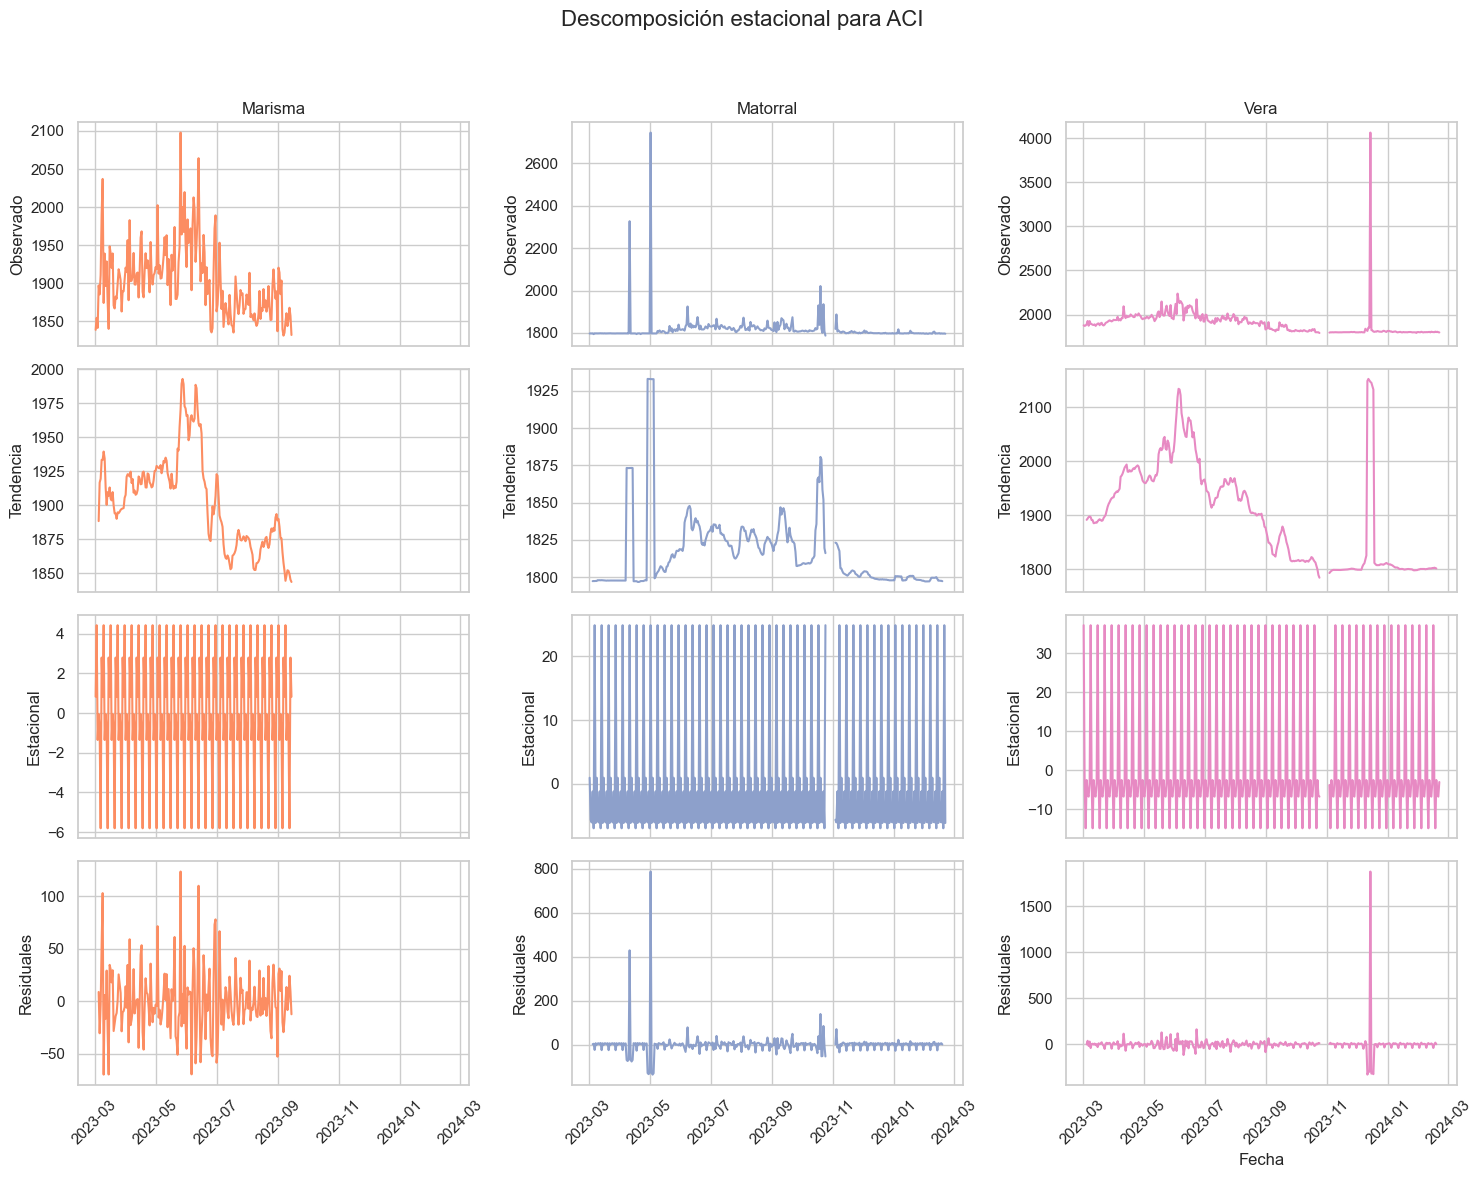

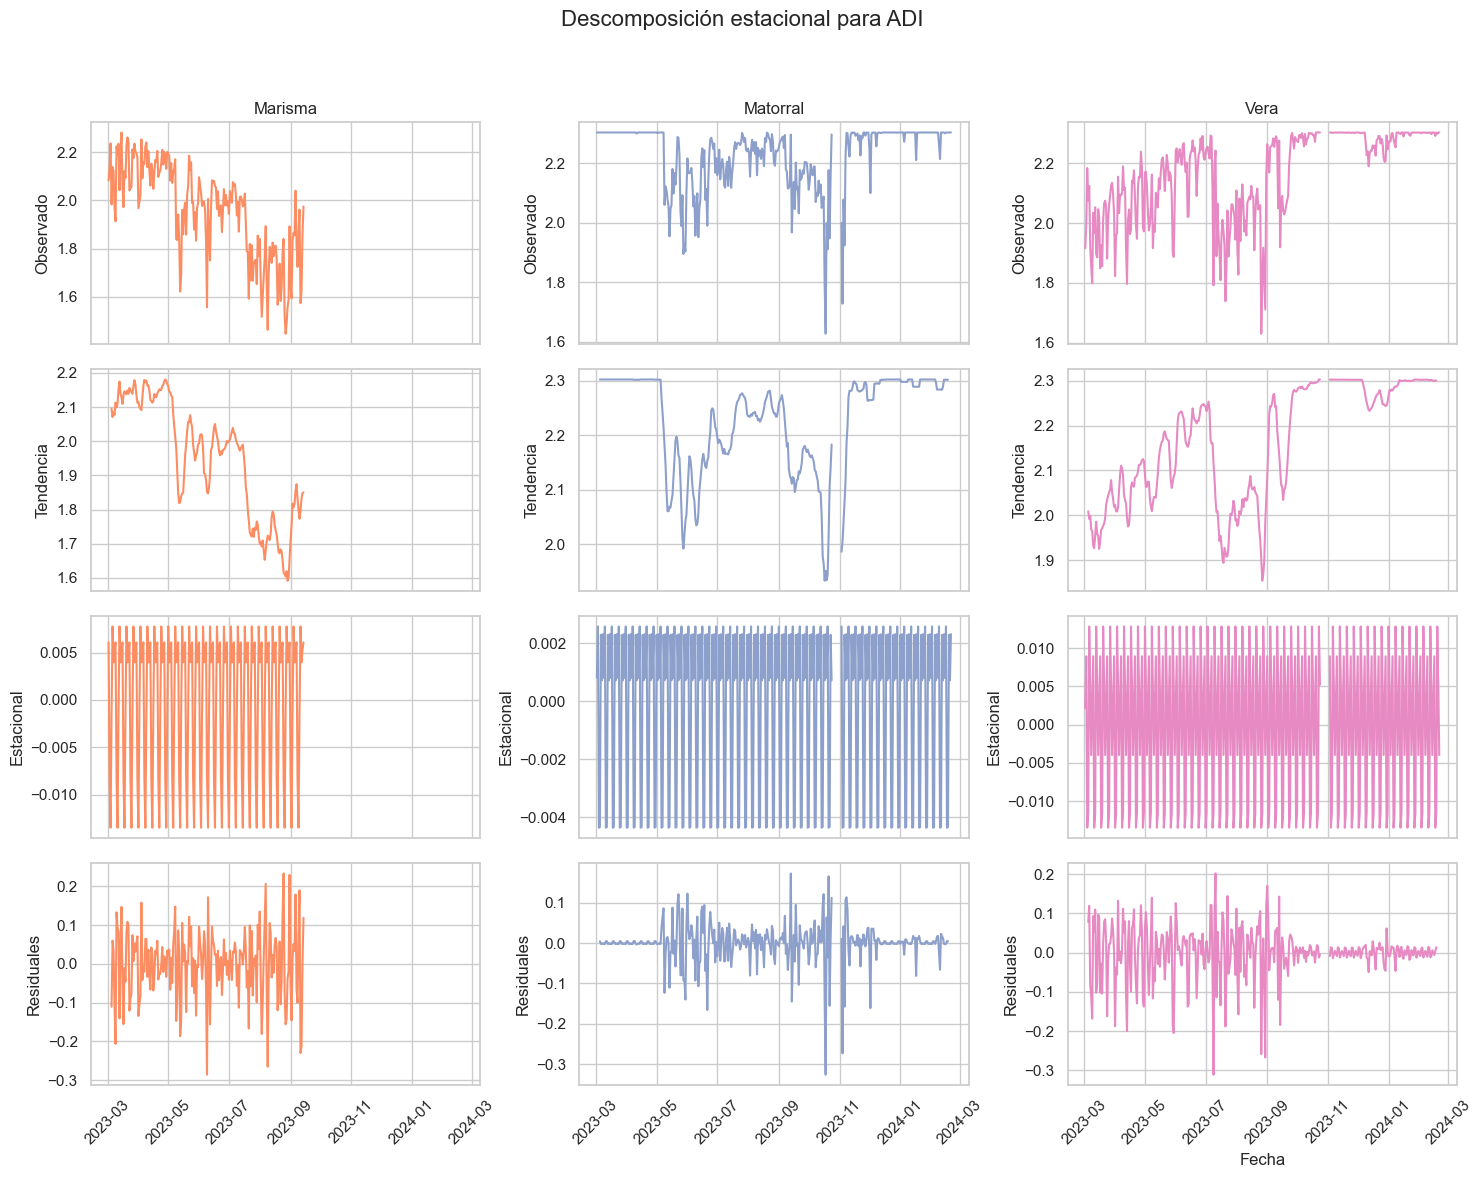

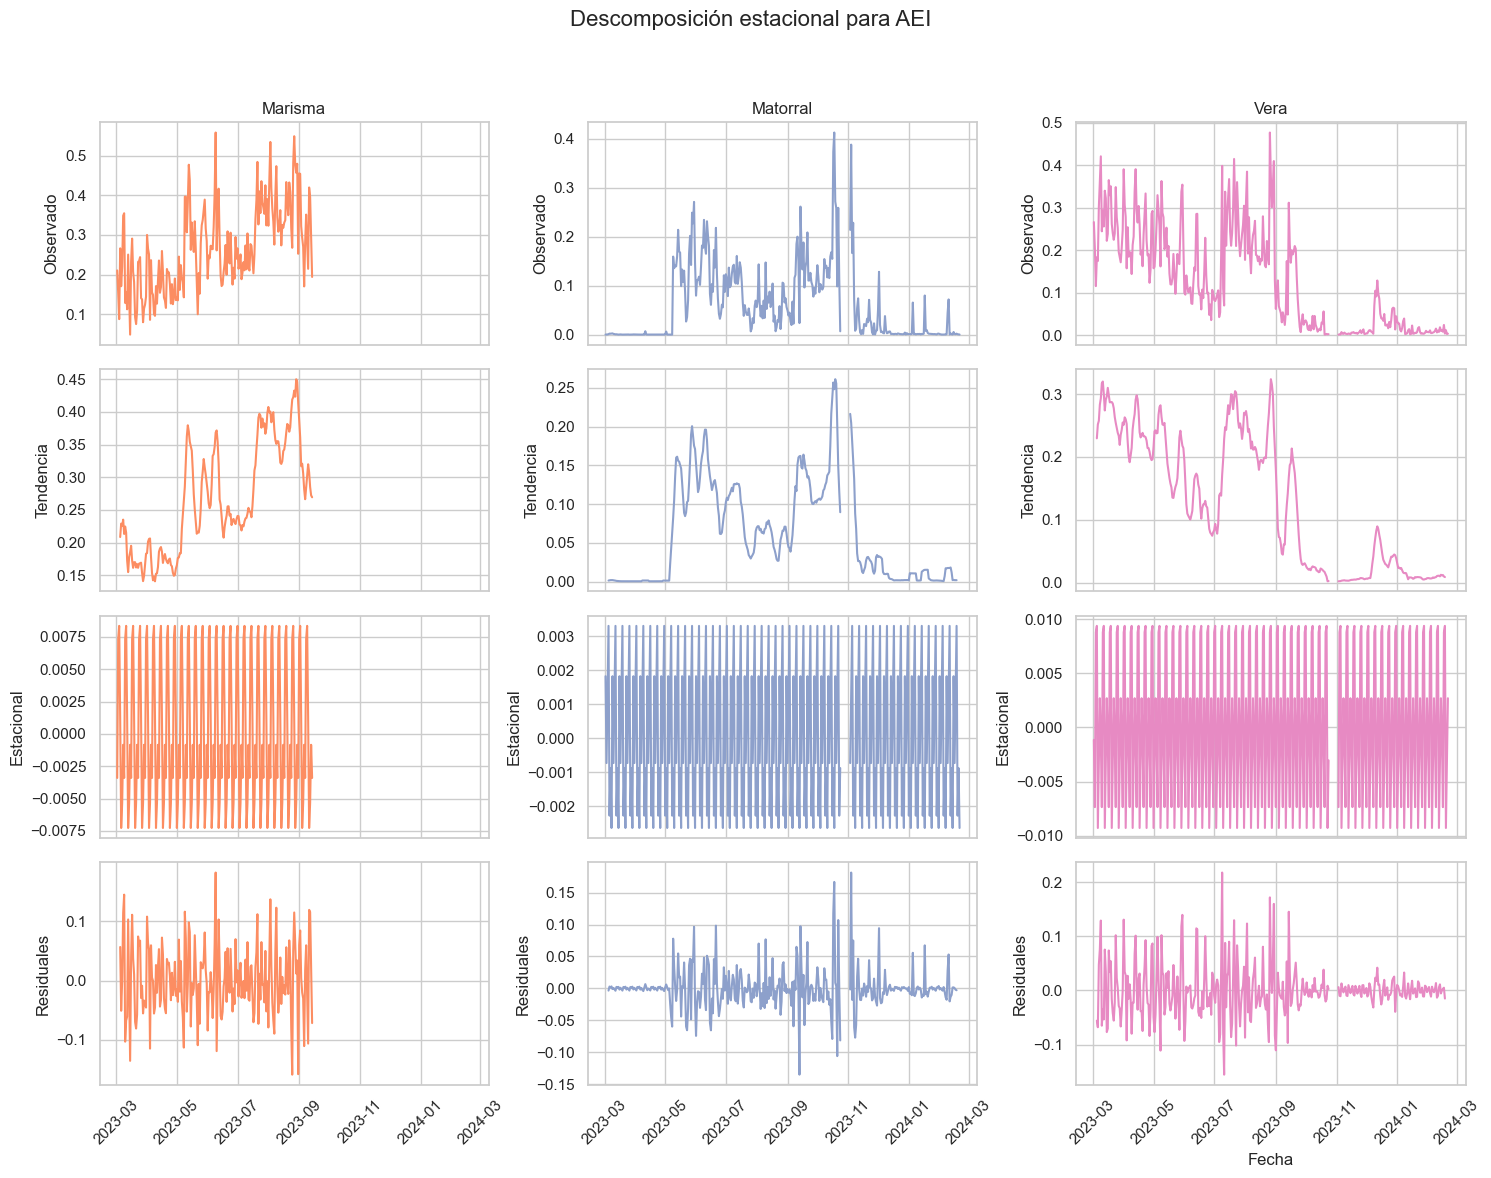

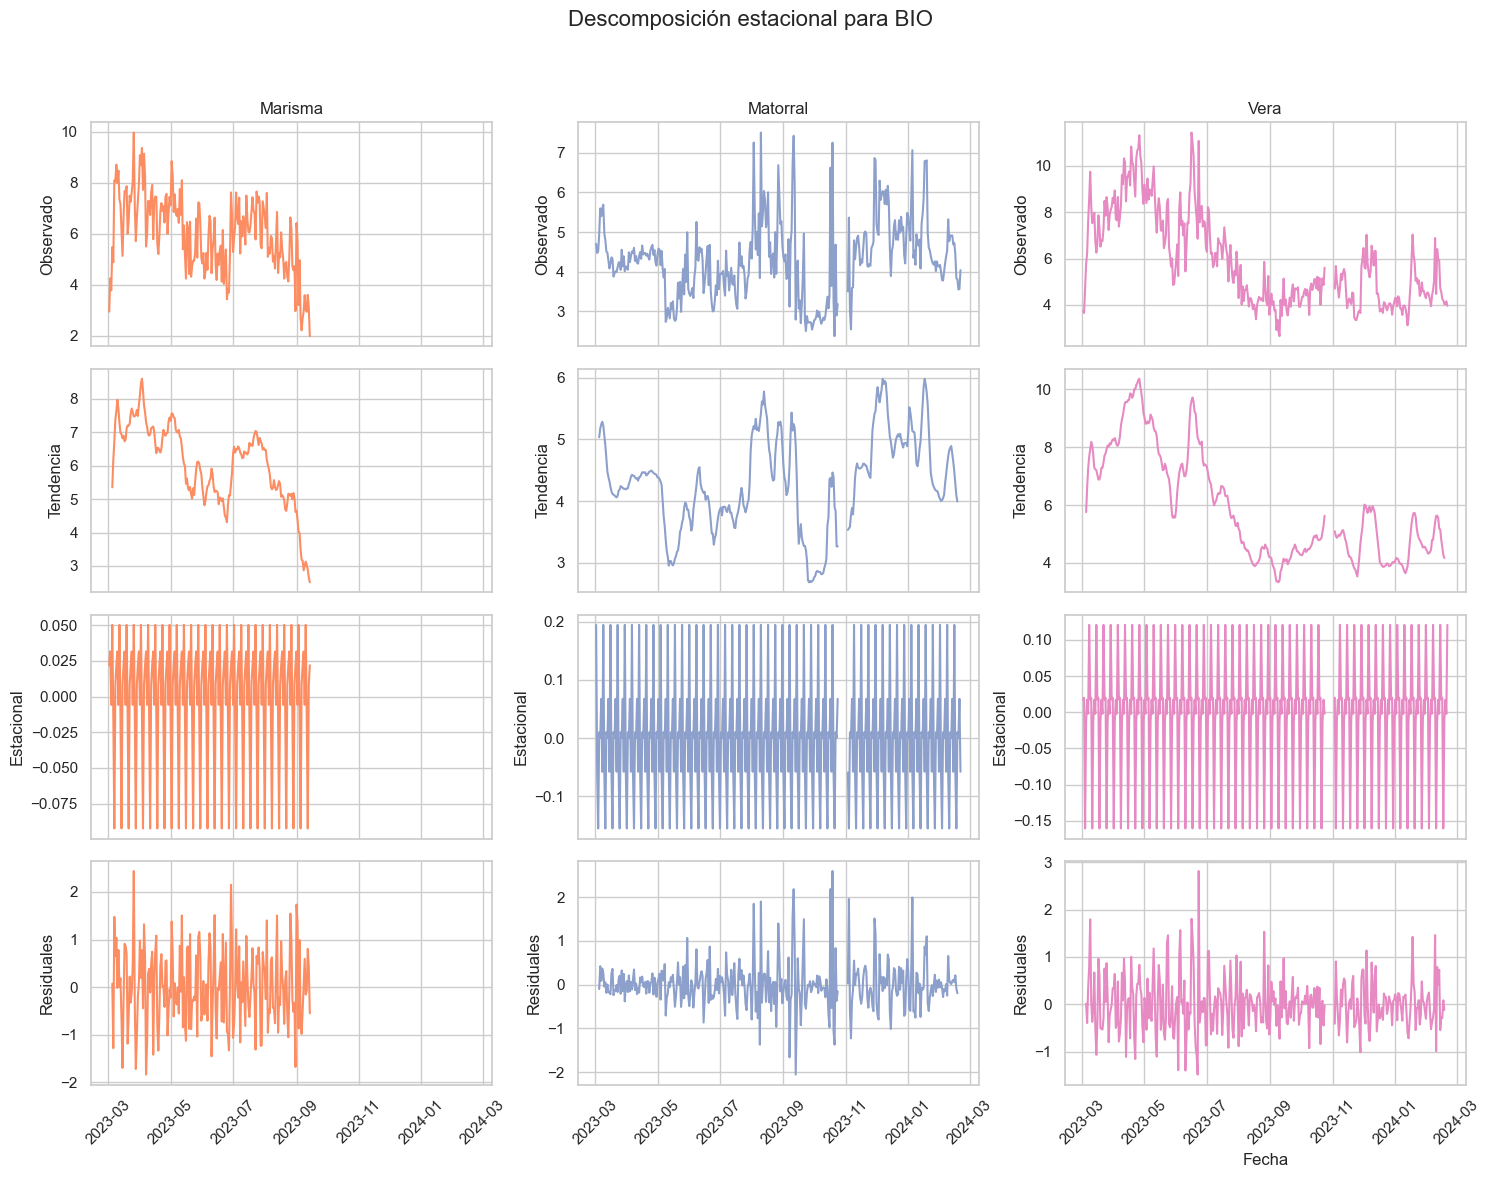

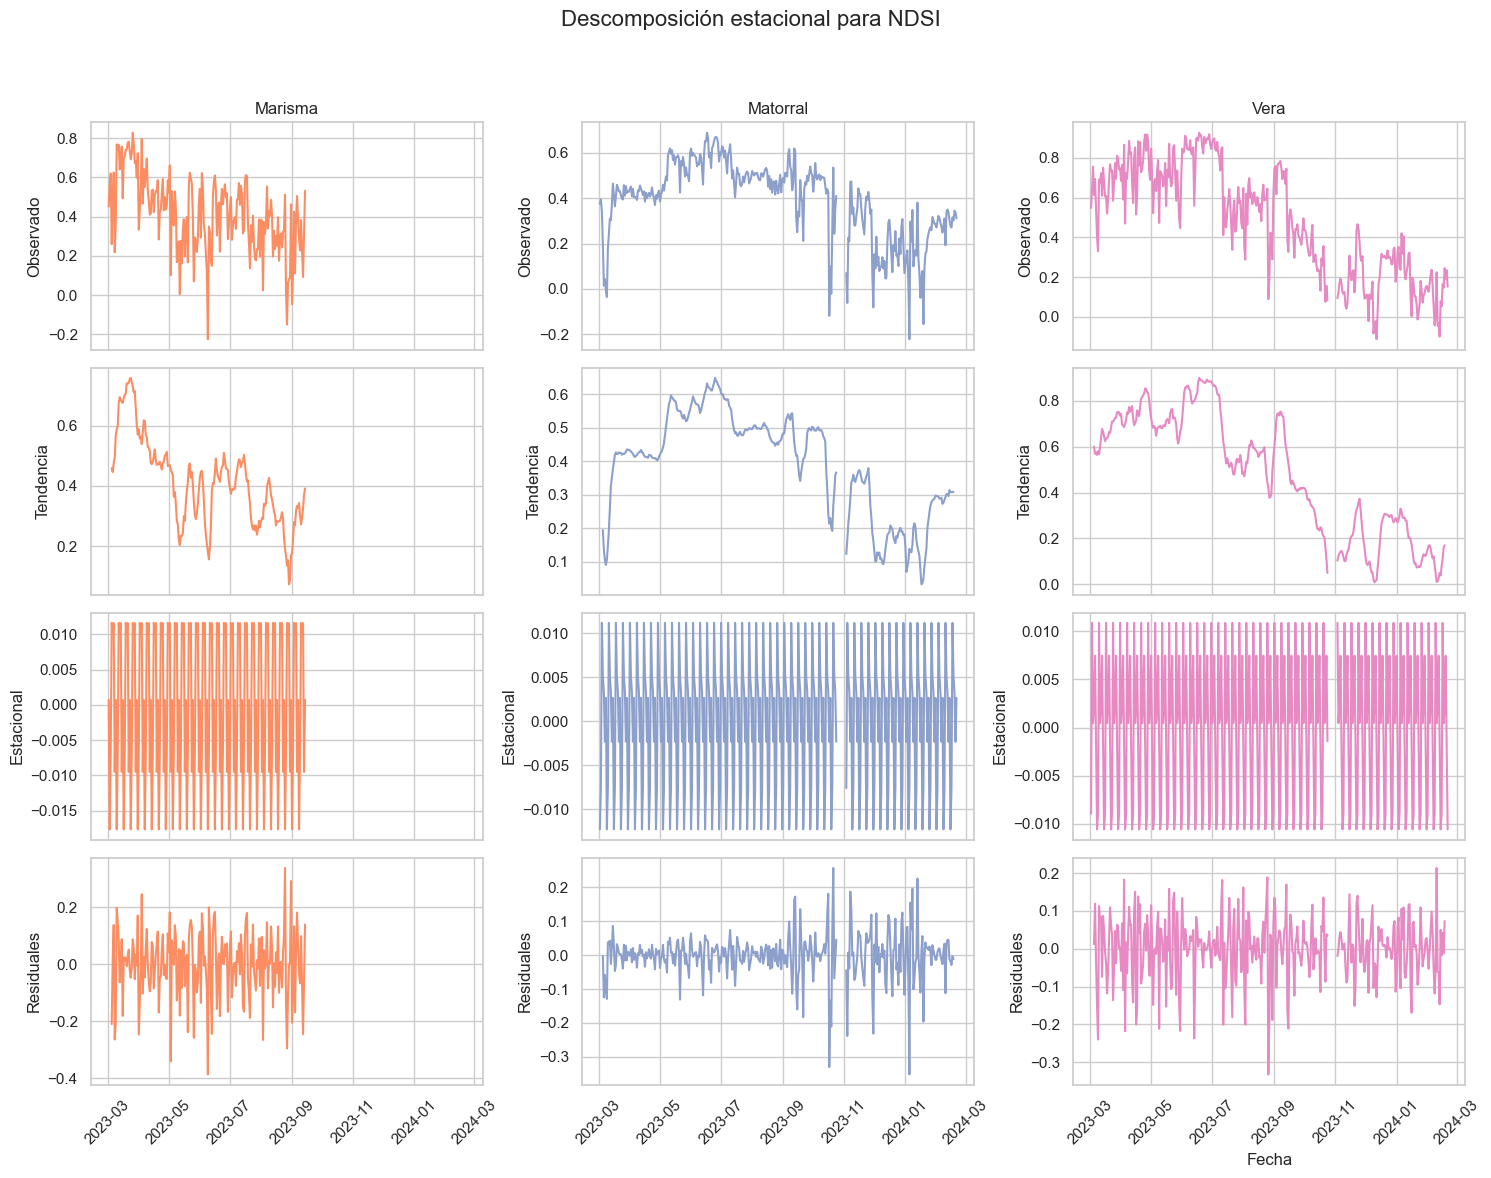

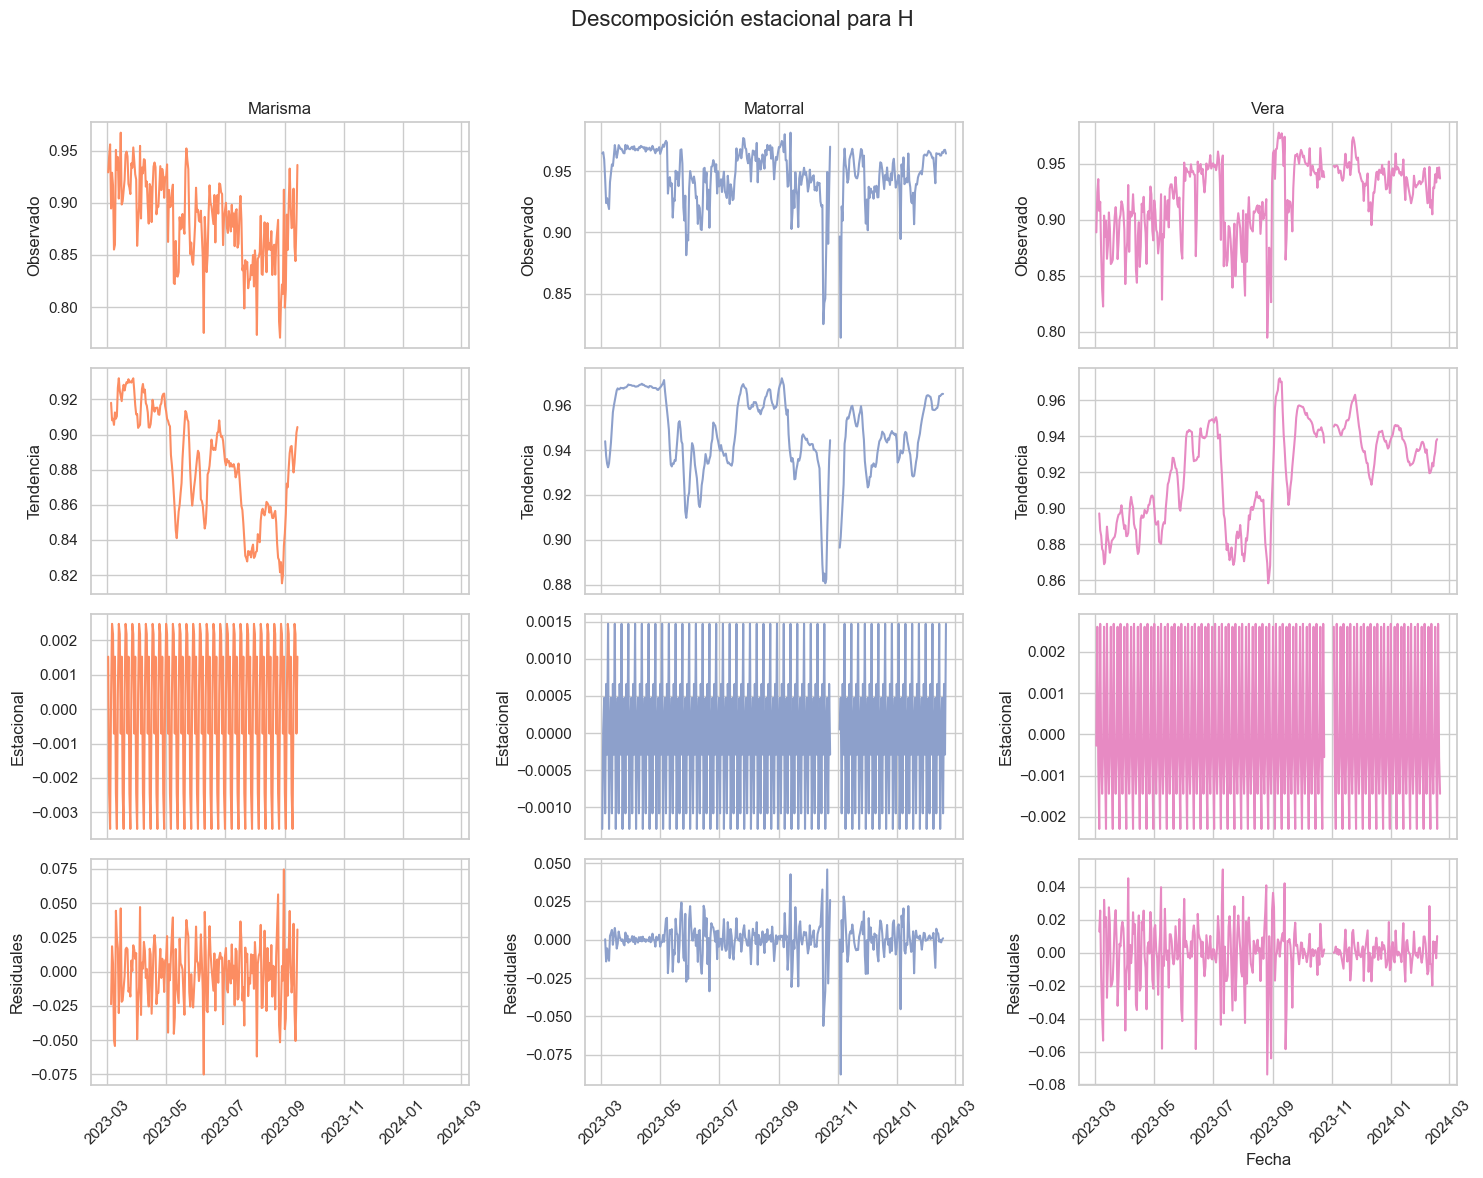

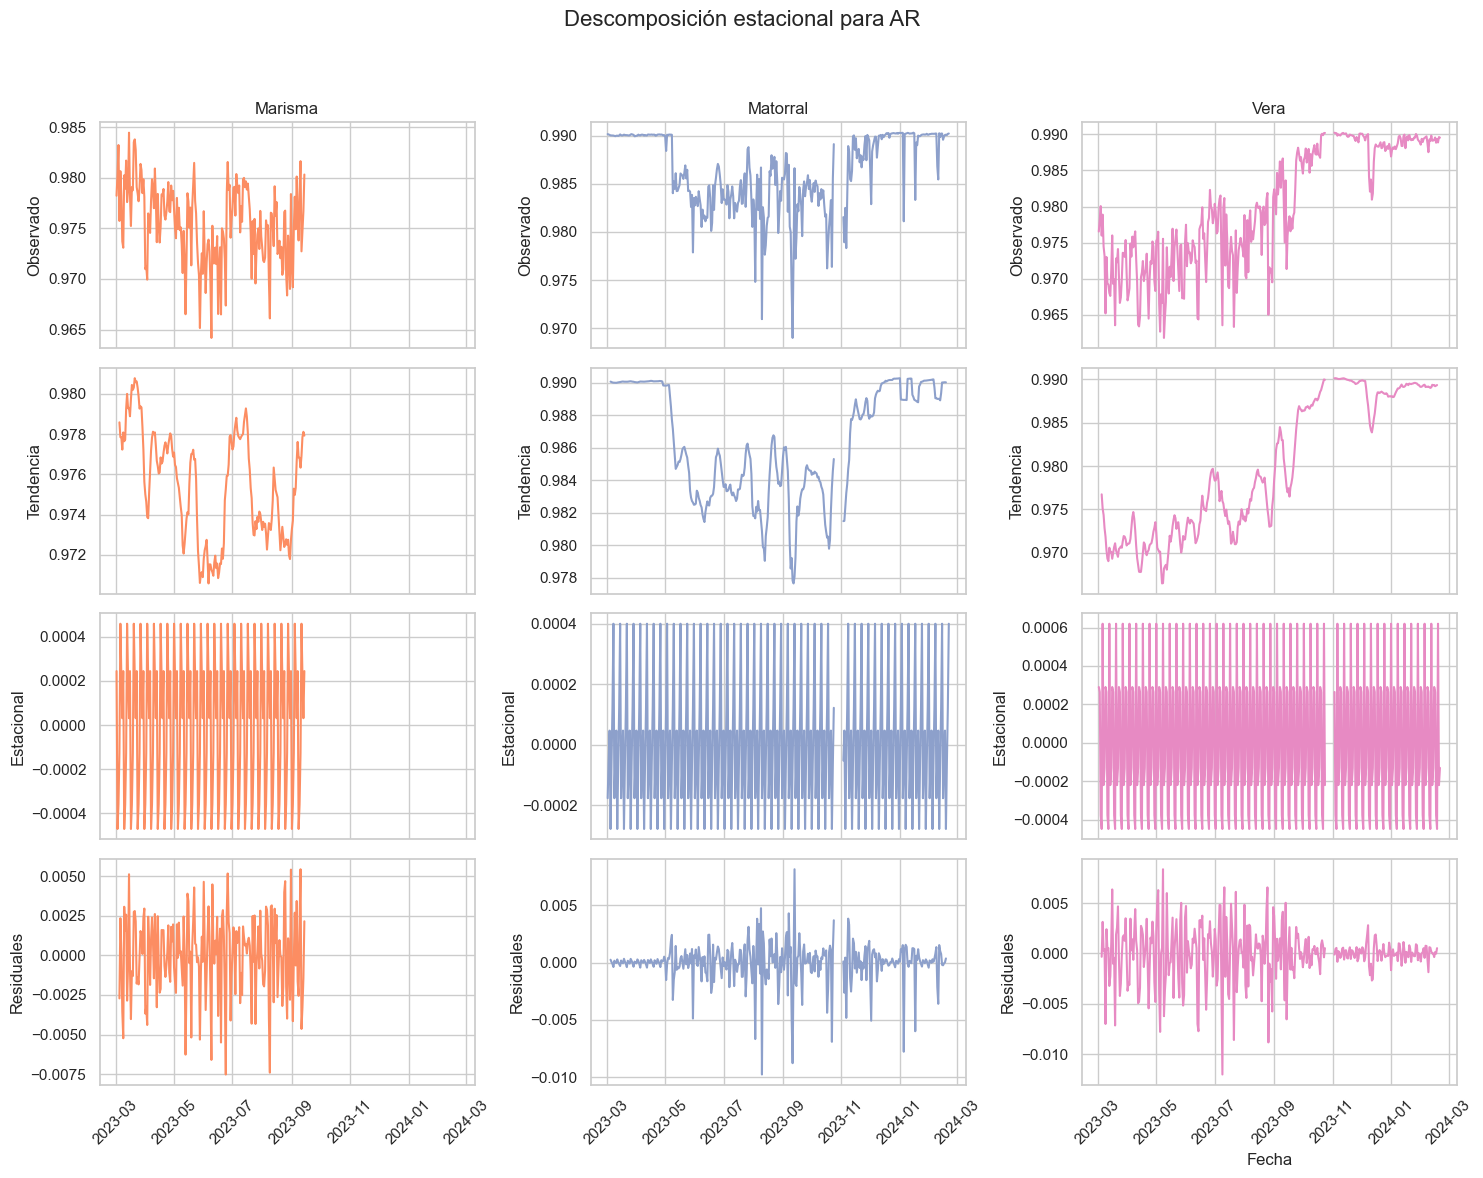

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 6. Descomposición estacional para cada índice con las zonas en la misma fila ---
for idx in indices:
    # Excluir la zona 'Laguna'
    sorted_zones_mod = [zone for zone in sorted_zones if zone != 'Laguna']
    n_zones = len(sorted_zones_mod)
    fig, axs = plt.subplots(4, n_zones, figsize=(5 * n_zones, 12), sharex=True)

    for col, zone in enumerate(sorted_zones_mod):
        # Extraer y reindexar la serie para la zona
        zone_data = daily_zone_filtered[daily_zone_filtered["zone"] == zone] \
                        .sort_values(by="day").set_index("day")
        zone_data = zone_data.reindex(full_date_range)
        ts = zone_data[idx]  # Serie con posibles huecos (NaN)

        # Verificar que hay suficientes datos no nulos para la descomposición (se recomienda al menos 2 períodos)
        if ts.dropna().shape[0] < 2 * 7:
            print(f"No hay suficientes datos para descomponer {idx} en la zona {zone}.")
            for row in range(4):
                axs[row, col].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axs[row, col].transAxes)
                axs[row, col].set_title(zone)
            continue

        # Guardar la máscara de los días sin datos y rellenar para aplicar la descomposición
        missing_mask = ts.isna()
        ts_filled = ts.interpolate(method='time')

        try:
            decomposition = seasonal_decompose(ts_filled, model='additive', period=7)
        except Exception as e:
            print(f"Error en la descomposición de {idx} para {zone}: {e}")
            for row in range(4):
                axs[row, col].text(0.5, 0.5, f"Error: {e}", ha='center', va='center', transform=axs[row, col].transAxes)
                axs[row, col].set_title(zone)
            continue

        # Reaplicar la máscara: en las posiciones originales sin datos se colocan NaN
        decomposition.observed[missing_mask] = np.nan
        decomposition.trend[missing_mask] = np.nan
        decomposition.seasonal[missing_mask] = np.nan
        decomposition.resid[missing_mask] = np.nan

        # Graficar cada componente en su respectivo subplot
        axs[0, col].plot(decomposition.observed, color=zone_colors[zone])
        axs[0, col].set_title(zone)
        axs[0, col].set_ylabel("Observado")

        axs[1, col].plot(decomposition.trend, color=zone_colors[zone])
        axs[1, col].set_ylabel("Tendencia")

        axs[2, col].plot(decomposition.seasonal, color=zone_colors[zone])
        axs[2, col].set_ylabel("Estacional")

        axs[3, col].plot(decomposition.resid, color=zone_colors[zone])
        axs[3, col].set_ylabel("Residuales")

    plt.suptitle(f"Descomposición estacional para {idx}", fontsize=16)
    plt.xlabel("Fecha")
    # Rotar los rótulos del eje x en la última fila
    for ax in axs[-1, :]:
        plt.setp(ax.get_xticklabels(), rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Índice: BIO

Modelo SARIMA óptimo para BIO en la zona Marisma:
Orden no estacional (p, d, q): (2, 1, 3)  |  Orden estacional (P, D, Q, s): (1, 1, 2, 7)  |  AIC: 507.9998
                                       SARIMAX Results                                        
Dep. Variable:                                    BIO   No. Observations:                  197
Model:             SARIMAX(2, 1, 3)x(1, 1, [1, 2], 7)   Log Likelihood                -245.000
Date:                                Sat, 05 Apr 2025   AIC                            508.000
Time:                                        14:45:11   BIC                            536.275
Sample:                                    03-02-2023   HQIC                           519.473
                                         - 09-14-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025   

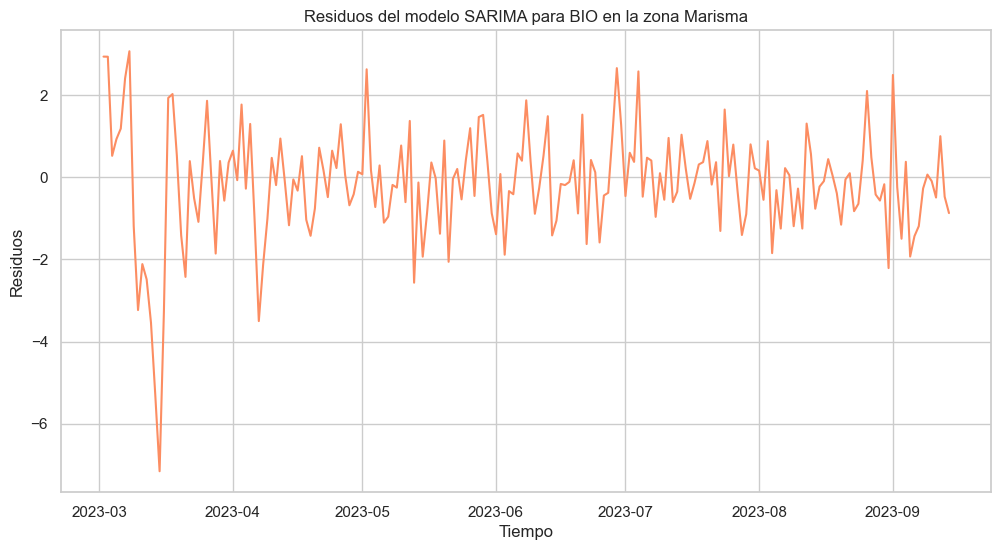

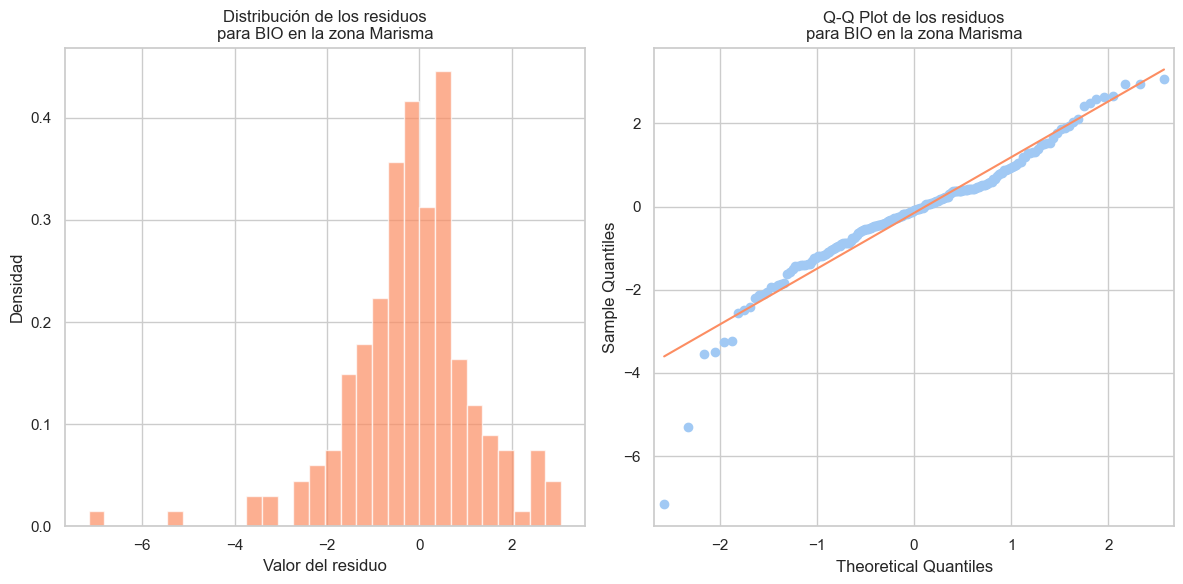

Prueba Shapiro-Wilk para BIO en la zona Marisma: Estadístico = 0.9399, p-value = 0.0000
Prueba Box-Ljung (lag=10) para BIO en la zona Marisma:
      lb_stat  lb_pvalue
10  39.155522   0.000024

Modelo SARIMA óptimo para BIO en la zona Matorral:
Orden no estacional (p, d, q): (3, 1, 3)  |  Orden estacional (P, D, Q, s): (0, 0, 2, 7)  |  AIC: 713.3431
                                       SARIMAX Results                                        
Dep. Variable:                                    BIO   No. Observations:                  348
Model:             SARIMAX(3, 1, 3)x(0, 0, [1, 2], 7)   Log Likelihood                -347.672
Date:                                Sat, 05 Apr 2025   AIC                            713.343
Time:                                        14:49:19   BIC                            747.508
Sample:                                    03-02-2023   HQIC                           726.972
                                         - 02-21-2024                         

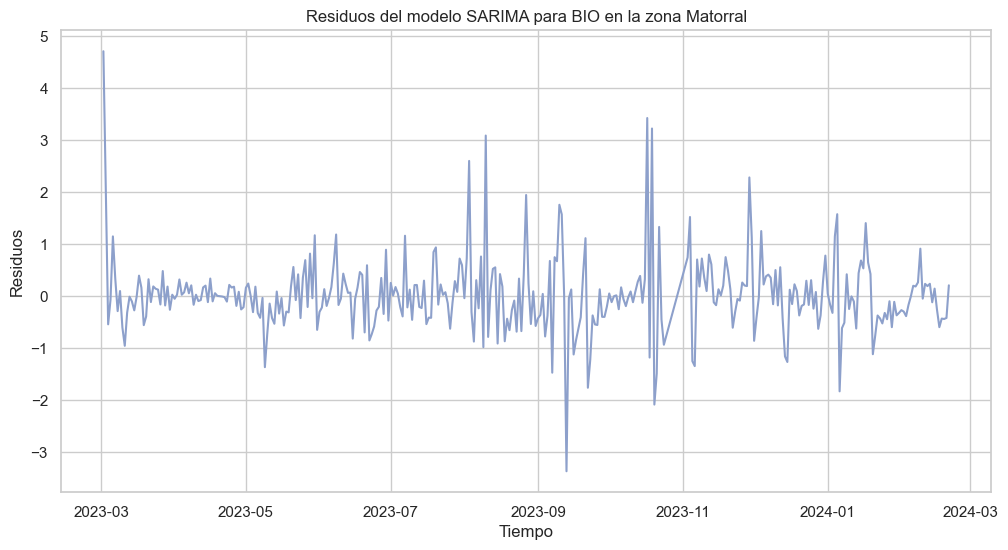

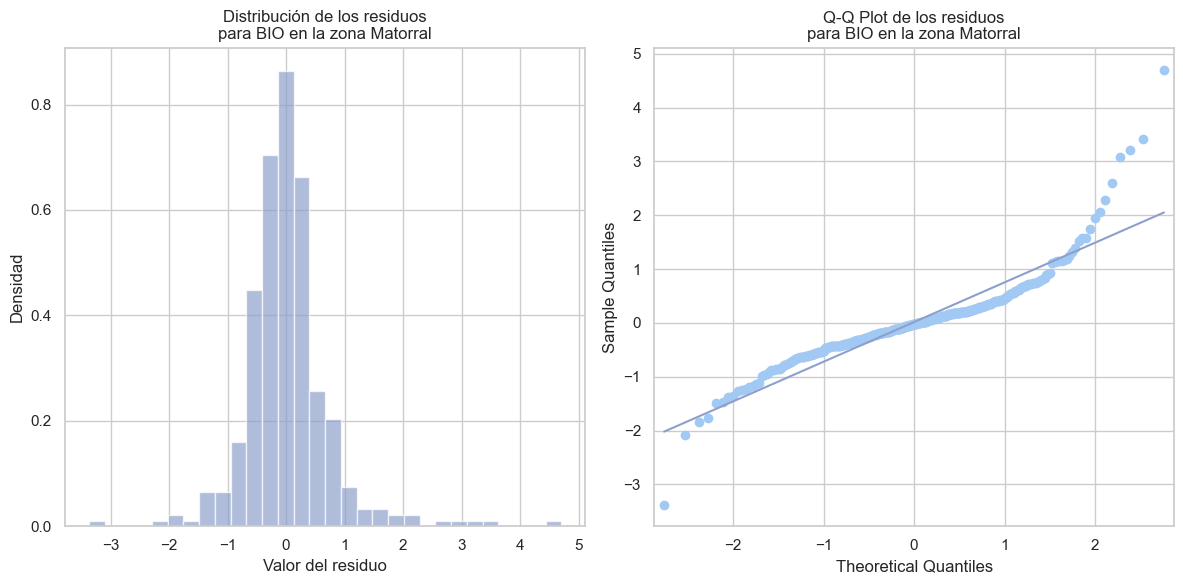

Prueba Shapiro-Wilk para BIO en la zona Matorral: Estadístico = 0.8684, p-value = 0.0000
Prueba Box-Ljung (lag=10) para BIO en la zona Matorral:
     lb_stat  lb_pvalue
10  5.814499     0.8306

Modelo SARIMA óptimo para BIO en la zona Vera:
Orden no estacional (p, d, q): (3, 1, 2)  |  Orden estacional (P, D, Q, s): (0, 0, 2, 7)  |  AIC: 750.8862
                                     SARIMAX Results                                     
Dep. Variable:                               BIO   No. Observations:                  349
Model:             SARIMAX(3, 1, 2)x(0, 0, 2, 7)   Log Likelihood                -367.443
Date:                           Sat, 05 Apr 2025   AIC                            750.886
Time:                                   14:54:12   BIC                            781.303
Sample:                               03-02-2023   HQIC                           763.018
                                    - 02-21-2024                                         
Covariance Type:      

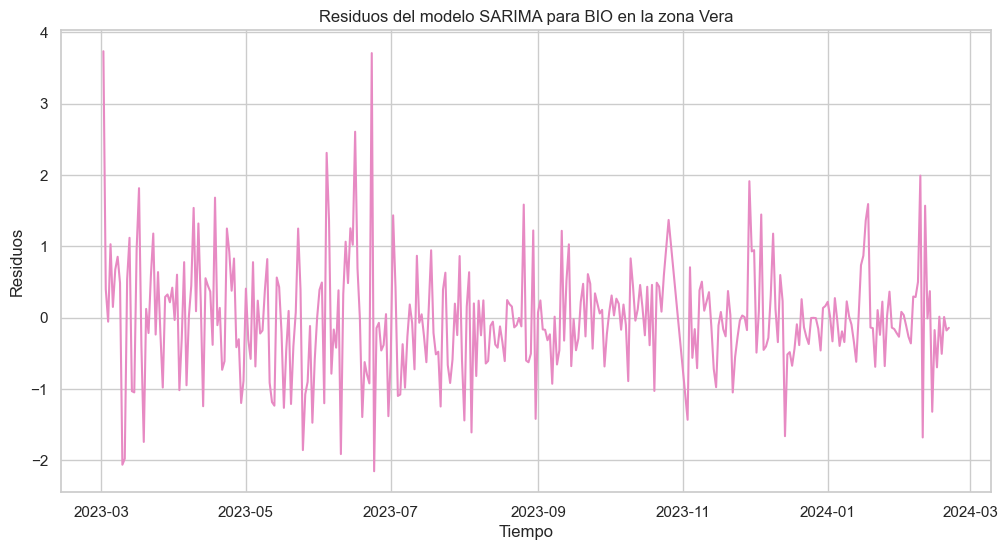

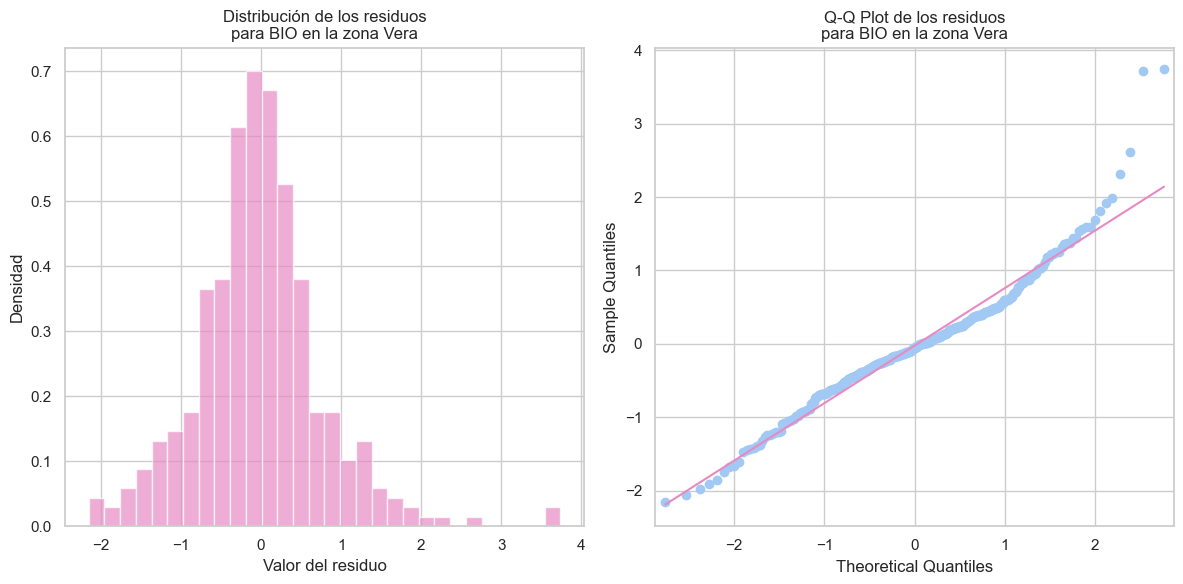

Prueba Shapiro-Wilk para BIO en la zona Vera: Estadístico = 0.9583, p-value = 0.0000
Prueba Box-Ljung (lag=10) para BIO en la zona Vera:
     lb_stat  lb_pvalue
10  8.321183   0.597496

Índice: NDSI

Modelo SARIMA óptimo para NDSI en la zona Marisma:
Orden no estacional (p, d, q): (2, 0, 1)  |  Orden estacional (P, D, Q, s): (0, 0, 1, 7)  |  AIC: -182.8555
                                     SARIMAX Results                                     
Dep. Variable:                              NDSI   No. Observations:                  197
Model:             SARIMAX(2, 0, 1)x(0, 0, 1, 7)   Log Likelihood                  96.428
Date:                           Sat, 05 Apr 2025   AIC                           -182.856
Time:                                   14:57:23   BIC                           -166.673
Sample:                               03-02-2023   HQIC                          -176.299
                                    - 09-14-2023                                         
Covariance 

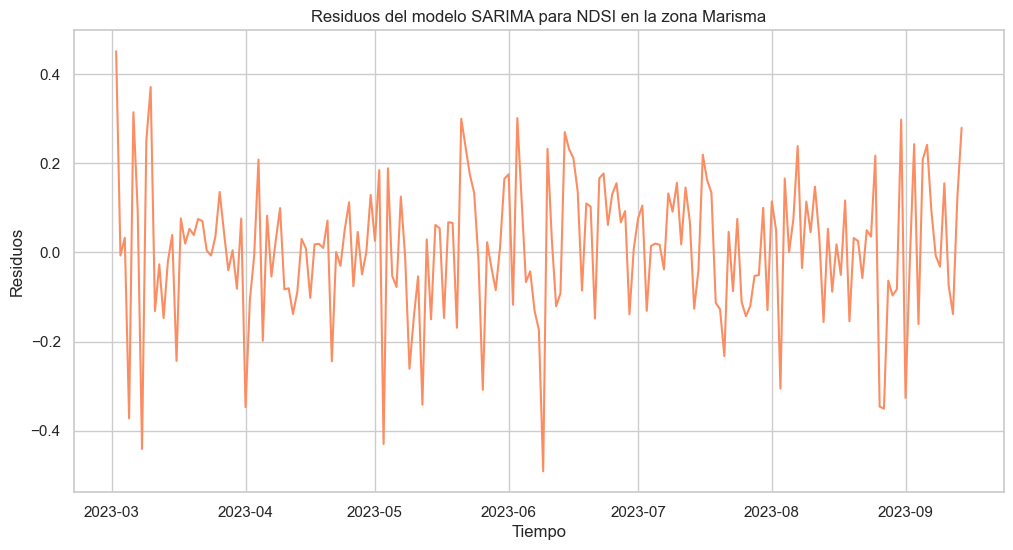

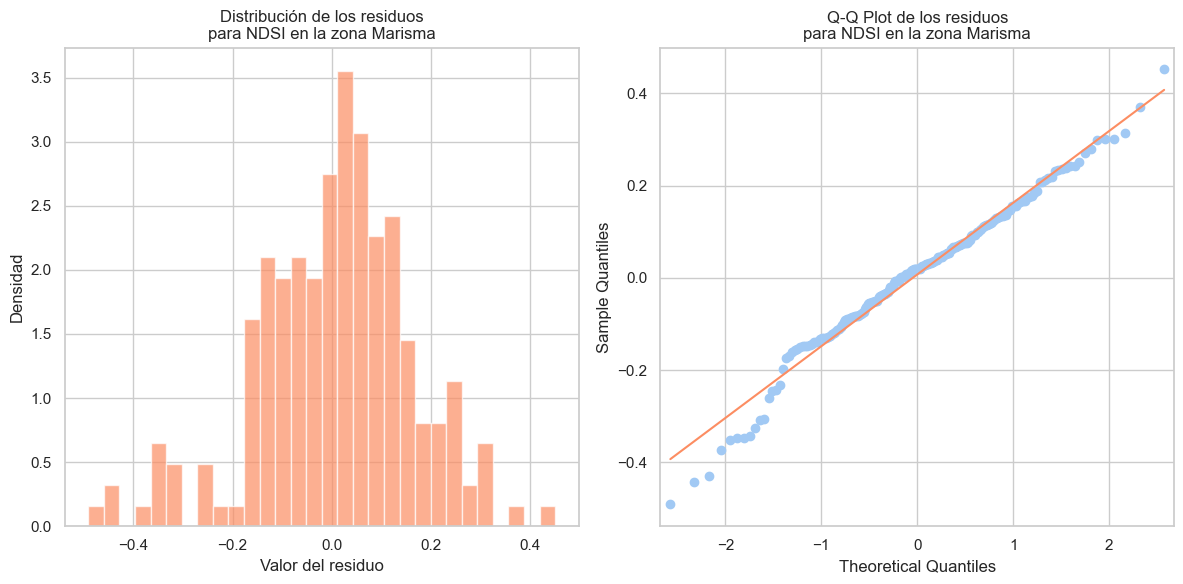

Prueba Shapiro-Wilk para NDSI en la zona Marisma: Estadístico = 0.9826, p-value = 0.0154
Prueba Box-Ljung (lag=10) para NDSI en la zona Marisma:
     lb_stat  lb_pvalue
10  6.564815   0.765791

Modelo SARIMA óptimo para NDSI en la zona Matorral:
Orden no estacional (p, d, q): (3, 1, 3)  |  Orden estacional (P, D, Q, s): (0, 0, 0, 7)  |  AIC: -733.9169
                               SARIMAX Results                                
Dep. Variable:                   NDSI   No. Observations:                  348
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 373.958
Date:                Sat, 05 Apr 2025   AIC                           -733.917
Time:                        15:02:43   BIC                           -707.053
Sample:                    03-02-2023   HQIC                          -723.216
                         - 02-21-2024                                         
Covariance Type:                  opg                                         
              

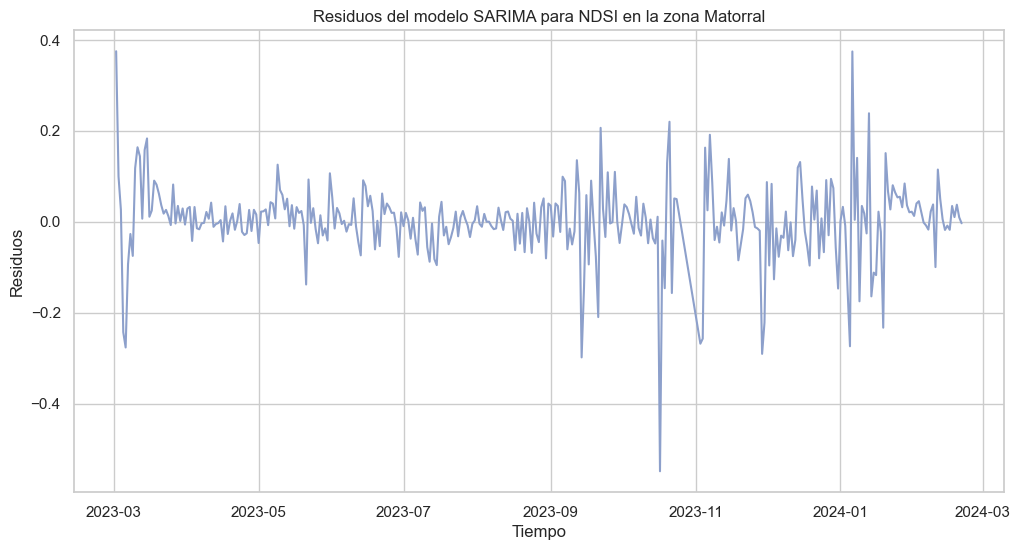

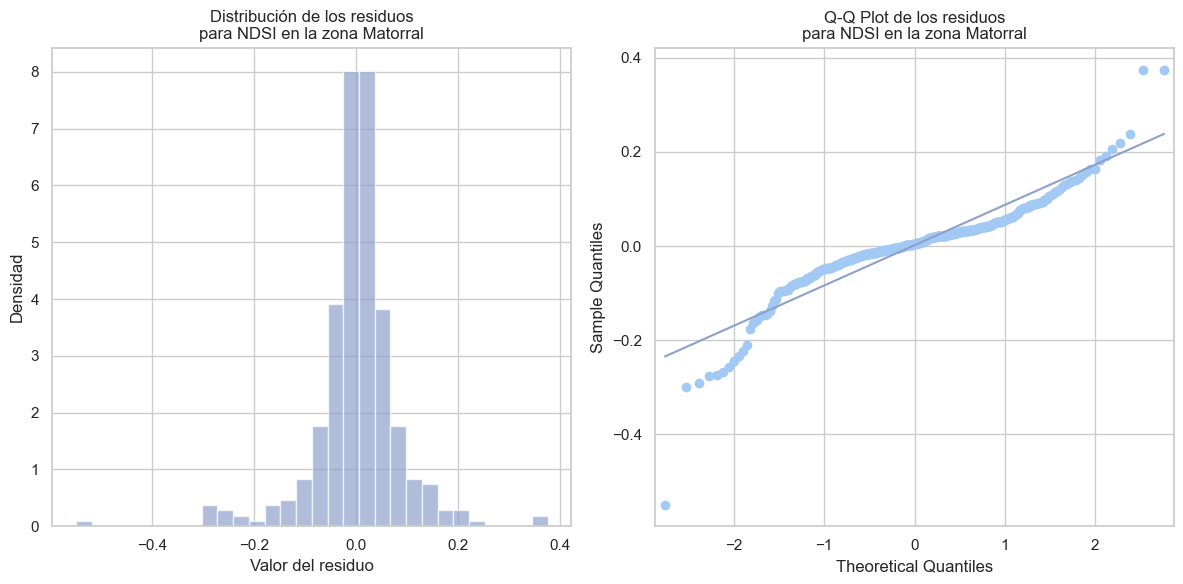

Prueba Shapiro-Wilk para NDSI en la zona Matorral: Estadístico = 0.8721, p-value = 0.0000
Prueba Box-Ljung (lag=10) para NDSI en la zona Matorral:
      lb_stat  lb_pvalue
10  10.894994   0.365757

Modelo SARIMA óptimo para NDSI en la zona Vera:
Orden no estacional (p, d, q): (2, 0, 1)  |  Orden estacional (P, D, Q, s): (0, 0, 0, 7)  |  AIC: -568.1832
                               SARIMAX Results                                
Dep. Variable:                   NDSI   No. Observations:                  349
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 288.092
Date:                Sat, 05 Apr 2025   AIC                           -568.183
Time:                        15:07:41   BIC                           -552.786
Sample:                    03-02-2023   HQIC                          -562.053
                         - 02-21-2024                                         
Covariance Type:                  opg                                         
              

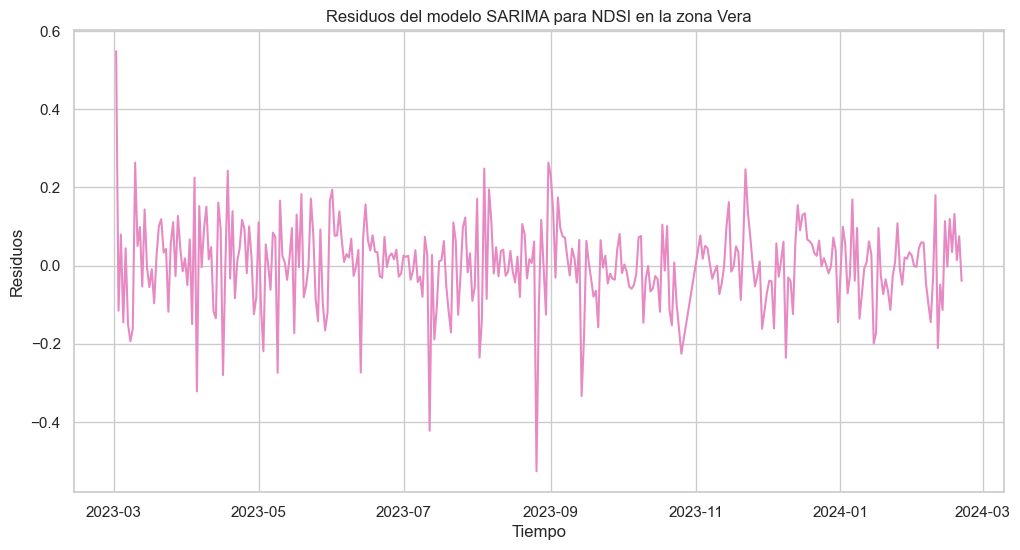

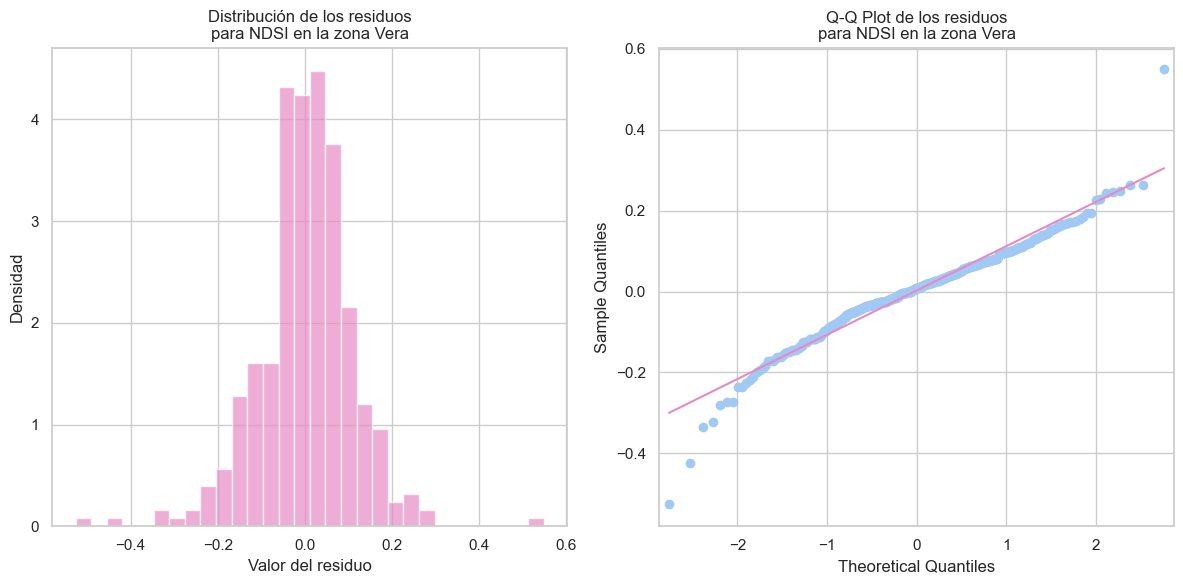

Prueba Shapiro-Wilk para NDSI en la zona Vera: Estadístico = 0.9590, p-value = 0.0000
Prueba Box-Ljung (lag=10) para NDSI en la zona Vera:
     lb_stat  lb_pvalue
10  6.655518   0.757517


In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import statsmodels.api as sm
import seaborn as sns

# Configuración de Seaborn para estilo pastel
sns.set_theme(style="whitegrid", palette="pastel")

# Asignar colores a cada zona usando la paleta Set2
# Se utiliza daily_zone_filtered para definir las zonas (o df_indices si se prefiere)
sorted_zones = sorted(df_indices["zone"].unique())
palette = sns.color_palette("Set2", n_colors=len(sorted_zones))
zone_colors = dict(zip(sorted_zones, palette))

# Se modelarán los índices BIO y NDSI
indices_to_model = ['BIO', 'NDSI']

# Definir las zonas a utilizar a partir de daily_zone_filtered
zones = sorted(daily_zone_filtered["zone"].unique())

# Definir el grid de parámetros para SARIMA:
# Parámetros no estacionales: p, d, q
p_values = range(0, 4)   # p: 0, 1, 2, 3
d_values = range(0, 2)   # d: 0, 1
q_values = range(0, 4)   # q: 0, 1, 2, 3

# Parámetros estacionales: P, D, Q y s (período)
P_values = range(0, 3)   # P: 0, 1, 2
D_values = range(0, 2)   # D: 0, 1
Q_values = range(0, 3)   # Q: 0, 1, 2
seasonal_period = 7      # Estacionalidad semanal (cada 7 días)

# Diccionario para guardar la información de cada modelo
results_info = {}

# Iterar sobre cada índice de interés
for idx in indices_to_model:
    results_info[idx] = {}
    print(f"\n{'='*50}\nÍndice: {idx}\n{'='*50}")

    # Iterar sobre cada zona
    for zone in zones:
        zone_results = {}
        # Extraer la serie diaria para la zona utilizando solo las fechas reales
        zone_data = daily_zone_filtered[daily_zone_filtered["zone"] == zone]\
                        .sort_values(by="day")\
                        .set_index("day")
        ts = zone_data[idx].dropna()  # Eliminar las fechas sin datos

        # Verificar que haya suficientes datos (al menos 10 observaciones)
        if ts.shape[0] < 10:
            print(f"\nZona {zone}: No hay suficientes datos para {idx}.")
            continue

        # Convertir el índice a PeriodIndex de frecuencia diaria
        ts.index = pd.to_datetime(ts.index).to_period('D')

        # --- Búsqueda en cuadrícula para el modelo SARIMA sobre toda la serie ---
        best_aic = np.inf
        best_order = None
        best_seasonal_order = None
        best_model = None

        # Grid search sobre los parámetros no estacionales y estacionales
        for order in itertools.product(p_values, d_values, q_values):
            for seasonal_order in itertools.product(P_values, D_values, Q_values):
                seasonal_order_full = seasonal_order + (seasonal_period,)
                try:
                    model = SARIMAX(ts, order=order, seasonal_order=seasonal_order_full,
                                    enforce_stationarity=False, enforce_invertibility=False)
                    model_fit = model.fit(disp=False)
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = order
                        best_seasonal_order = seasonal_order_full
                        best_model = model_fit
                except Exception as e:
                    continue

        if best_model is not None:
            print(f"\nModelo SARIMA óptimo para {idx} en la zona {zone}:")
            print(f"Orden no estacional (p, d, q): {best_order}  |  Orden estacional (P, D, Q, s): {best_seasonal_order}  |  AIC: {best_aic:.4f}")
            print(best_model.summary())

            # --- Estudio de residuos ---
            resid = best_model.resid

            # Prueba de Ljung-Box para evaluar autocorrelación en los residuos (lag=10)
            lb_test = acorr_ljungbox(resid, lags=[10], return_df=True)

            # Prueba de Jarque-Bera para evaluar normalidad
            jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(resid)

            # Aplicar la prueba Shapiro-Wilk a los residuos
            shapiro_stat, shapiro_pvalue = shapiro(resid)

            # Guardar la información del modelo y de los residuos en el diccionario
            zone_results['best_order'] = best_order
            zone_results['best_seasonal_order'] = best_seasonal_order
            zone_results['AIC'] = best_aic
            zone_results['model_summary'] = best_model.summary().as_text()
            zone_results['residuals_mean'] = np.mean(resid)
            zone_results['residuals_std'] = np.std(resid)
            zone_results['ljung_box'] = lb_test.to_dict(orient='records')
            zone_results['jarque_bera'] = {
                'statistic': jb_stat,
                'pvalue': jb_pvalue,
                'skew': jb_skew,
                'kurtosis': jb_kurtosis
            }
            zone_results['shapiro_wilk'] = {
                'statistic': shapiro_stat,
                'pvalue': shapiro_pvalue
            }
            zone_results['residuals'] = resid

            results_info[idx][zone] = zone_results

            # Visualización de la serie de residuos (tiempo)
            plt.figure(figsize=(12, 6))
            plt.plot(resid.index.to_timestamp(), resid, color=zone_colors[zone])
            plt.title(f"Residuos del modelo SARIMA para {idx} en la zona {zone}")
            plt.xlabel("Tiempo")
            plt.ylabel("Residuos")
            plt.show()

            # Gráficos combinados: Distribución y Q-Q Plot de los residuos en la misma fila
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            # Histograma (distribución de residuos)
            axes[0].hist(resid, bins=30, density=True, alpha=0.7, color=zone_colors[zone])
            axes[0].set_title(f"Distribución de los residuos\npara {idx} en la zona {zone}")
            axes[0].set_xlabel("Valor del residuo")
            axes[0].set_ylabel("Densidad")
            # Q-Q Plot
            sm.qqplot(resid, line='s', ax=axes[1])
            axes[1].set_title(f"Q-Q Plot de los residuos\npara {idx} en la zona {zone}")
            # Intentar cambiar el color de los puntos al color de la zona (si es posible)
            for line in axes[1].get_lines():
                line.set_color(zone_colors[zone])
            plt.tight_layout()
            plt.show()

            # Imprimir resultados de las pruebas de residuos
            print(f"Prueba Shapiro-Wilk para {idx} en la zona {zone}: Estadístico = {shapiro_stat:.4f}, p-value = {shapiro_pvalue:.4f}")
            print(f"Prueba Box-Ljung (lag=10) para {idx} en la zona {zone}:\n{lb_test}")

        else:
            print(f"\nNo se encontró un modelo adecuado para {idx} en la zona {zone}.")

# La variable results_info contiene toda la información extraída de cada modelo

In [ ]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Se modelarán los índices BIO y NDSI
indices_to_model = ['BIO', 'NDSI']

# Definir las zonas a utilizar a partir de daily_zone_filtered
zones = sorted(daily_zone_filtered["zone"].unique())

# Definir el grid de parámetros para SARIMA:
# Parámetros no estacionales: p, d, q
p_values = range(0, 4)   # p: 0, 1, 2, 3, 4
d_values = range(0, 2)   # d: 0, 1, 2, 3
q_values = range(0, 4)   # q: 0, 1, 2, 3, 4

# Parámetros estacionales: P, D, Q y s (período)
P_values = range(0, 3)   # P: 0, 1, 2
D_values = range(0, 2)   # D: 0, 1
Q_values = range(0, 3)   # Q: 0, 1, 2
seasonal_period = 7      # Estacionalidad semanal (cada 7 días)

# Iterar sobre cada índice de interés
for idx in indices_to_model:
    print(f"\n{'='*50}\nÍndice: {idx}\n{'='*50}")

    # Iterar sobre cada zona
    for zone in zones:
        # Extraer la serie diaria para la zona utilizando solo las fechas reales
        zone_data = daily_zone_filtered[daily_zone_filtered["zone"] == zone]\
                        .sort_values(by="day")\
                        .set_index("day")
        ts = zone_data[idx].dropna()  # Se eliminan las fechas sin datos

        # Verificar que haya suficientes datos (al menos 10 observaciones)
        if ts.shape[0] < 10:
            print(f"\nZona {zone}: No hay suficientes datos para {idx}.")
            continue

        # Convertir el índice a PeriodIndex de frecuencia diaria
        ts.index = pd.to_datetime(ts.index).to_period('D')

        # --- Búsqueda en cuadrícula para el modelo SARIMA sobre toda la serie ---
        best_aic = np.inf
        best_order = None
        best_seasonal_order = None
        best_model = None

        # Grid search sobre los parámetros no estacionales y estacionales
        for order in itertools.product(p_values, d_values, q_values):
            for seasonal_order in itertools.product(P_values, D_values, Q_values):
                seasonal_order_full = seasonal_order + (seasonal_period,)
                try:
                    model = SARIMAX(ts, order=order, seasonal_order=seasonal_order_full,
                                    enforce_stationarity=False, enforce_invertibility=False)
                    model_fit = model.fit(disp=False)
                    aic = model_fit.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = order
                        best_seasonal_order = seasonal_order_full
                        best_model = model_fit
                except Exception as e:
                    continue

        if best_model is not None:
            print(f"\nModelo SARIMA óptimo para {idx} en la zona {zone}:")
            print(f"Orden no estacional (p, d, q): {best_order}  |  Orden estacional (P, D, Q, s): {best_seasonal_order}  |  AIC: {best_aic:.4f}")
            print(best_model.summary())
        else:
            print(f"\nNo se encontró un modelo adecuado para {idx} en la zona {zone}.")


Índice: BIO


c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 


Modelo SARIMA óptimo para BIO en la zona Marisma:
Orden no estacional (p, d, q): (2, 1, 3)  |  Orden estacional (P, D, Q, s): (1, 1, 2, 7)  |  AIC: 507.9998
                                       SARIMAX Results                                        
Dep. Variable:                                    BIO   No. Observations:                  197
Model:             SARIMAX(2, 1, 3)x(1, 1, [1, 2], 7)   Log Likelihood                -245.000
Date:                                Sat, 05 Apr 2025   AIC                            508.000
Time:                                        03:07:26   BIC                            536.275
Sample:                                    03-02-2023   HQIC                           519.473
                                         - 09-14-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 


Modelo SARIMA óptimo para BIO en la zona Matorral:
Orden no estacional (p, d, q): (3, 1, 3)  |  Orden estacional (P, D, Q, s): (0, 0, 2, 7)  |  AIC: 713.3431
                                       SARIMAX Results                                        
Dep. Variable:                                    BIO   No. Observations:                  348
Model:             SARIMAX(3, 1, 3)x(0, 0, [1, 2], 7)   Log Likelihood                -347.672
Date:                                Sat, 05 Apr 2025   AIC                            713.343
Time:                                        03:11:43   BIC                            747.508
Sample:                                    03-02-2023   HQIC                           726.972
                                         - 02-21-2024                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--

c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 


Modelo SARIMA óptimo para BIO en la zona Vera:
Orden no estacional (p, d, q): (3, 1, 2)  |  Orden estacional (P, D, Q, s): (0, 0, 2, 7)  |  AIC: 750.8862
                                     SARIMAX Results                                     
Dep. Variable:                               BIO   No. Observations:                  349
Model:             SARIMAX(3, 1, 2)x(0, 0, 2, 7)   Log Likelihood                -367.443
Date:                           Sat, 05 Apr 2025   AIC                            750.886
Time:                                   03:16:11   BIC                            781.303
Sample:                               03-02-2023   HQIC                           763.018
                                    - 02-21-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 


Modelo SARIMA óptimo para NDSI en la zona Marisma:
Orden no estacional (p, d, q): (2, 0, 1)  |  Orden estacional (P, D, Q, s): (0, 0, 1, 7)  |  AIC: -182.8555
                                     SARIMAX Results                                     
Dep. Variable:                              NDSI   No. Observations:                  197
Model:             SARIMAX(2, 0, 1)x(0, 0, 1, 7)   Log Likelihood                  96.428
Date:                           Sat, 05 Apr 2025   AIC                           -182.856
Time:                                   03:19:27   BIC                           -166.673
Sample:                               03-02-2023   HQIC                          -176.299
                                    - 09-14-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 


Modelo SARIMA óptimo para NDSI en la zona Matorral:
Orden no estacional (p, d, q): (3, 1, 3)  |  Orden estacional (P, D, Q, s): (0, 0, 0, 7)  |  AIC: -733.9169
                               SARIMAX Results                                
Dep. Variable:                   NDSI   No. Observations:                  348
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 373.958
Date:                Sat, 05 Apr 2025   AIC                           -733.917
Time:                        03:24:57   BIC                           -707.053
Sample:                    03-02-2023   HQIC                          -723.216
                         - 02-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4282      0.053     -8.005      

c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 


Modelo SARIMA óptimo para NDSI en la zona Vera:
Orden no estacional (p, d, q): (2, 0, 1)  |  Orden estacional (P, D, Q, s): (0, 0, 0, 7)  |  AIC: -568.1832
                               SARIMAX Results                                
Dep. Variable:                   NDSI   No. Observations:                  349
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 288.092
Date:                Sat, 05 Apr 2025   AIC                           -568.183
Time:                        03:30:10   BIC                           -552.786
Sample:                    03-02-2023   HQIC                          -562.053
                         - 02-21-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3813      0.086     16.059      0.00

c:\Users\gonibix23\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
